In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### This notebook was created to find all of the High Quality SNV calls for all of the isolates in a DataBase with ~33k VCF files from processed FASTQ files that were downloaded from NCBI

In [2]:
import vcf

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from itertools import compress
from pylab import MaxNLocator
import seaborn as sns; sns.set()
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import ast
import itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
from sklearn.cluster import KMeans
import time
import sys

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import itertools
import gzip

import networkx as nx
import scipy
import pickle

####################################################################################################################################################################################

## [1] This section of the notebook loads all of the Lineage Calls that were made on the isolates in rollingDB as well as the mean coverage / isolates for all of the isolates in rollingDB. 

####################################################################################################################################################################################

#### We runs through the pilon-generated VCF for each isolate (N = 33,875) and scrapes the High Quality Single Nucleotide Variant calls made against H37Rv. The DataFrame containing these high quality SNV calls (with the Reference Position, Reference Allele and Alterante Allele) for each isolate is then stored in a directory containing all of the DFs for all isolates. 

#### Side-Note: Some isolate have ~20x coverage but we require 25 reads at a given position to make a SNP call

### Scrape Luca's DB

In [3]:
#genomic data directory
rolling_DB_dir = '/n/data1/hms/dbmi/farhat/rollingDB/genomic_data/'

#get all folders (each folder corresponds to a different sequenced isolate)
isolate_directories = os.listdir(rolling_DB_dir)

#iterate through each sequenced isolate
isolate_i = 0

for isolate_ID in isolate_directories:

    #directory that stores files for each sequenced isolate
    directory_for_sequenced_isolate = rolling_DB_dir + isolate_ID

    #check to see if megapipe successfully ran on sequenced isolate
    try:
        #existence of a PILON directory and corresponding VCF file
        if ( 'pilon' in os.listdir(directory_for_sequenced_isolate) ):
            
            #existence of a REDUCED VCF and existence of FULL VCF file in relevent directories 
            if ( 'vcf' in list( itertools.chain.from_iterable( [filename.split('.') for filename in os.listdir(directory_for_sequenced_isolate + '/pilon/')] ) ) ) and ( isolate_ID + '_full' in list( itertools.chain.from_iterable( [filename.split('.') for filename in os.listdir(directory_for_sequenced_isolate + '/pilon/')] ) ) ):
                
                #we have a valid VCF file so megapipe ran successfully, let's keep the variant call information for this sequenced isolate
                
                #PILON-generated VCF DATA
                ########################################################################################################################
                
                #dictionaries to construct DataFrame from later that hold information about each high-quality SNP found for a specific isolate from rollingDB
                ref_dict = {} #reference allele
                alt_dict = {} #alternate allele
                alt_AF_dict = {} #frequency of alternate allele in population (0.90 - 1.0)
                
                #load in VCF file if one was found
                vcf_reader = vcf.Reader( open(directory_for_sequenced_isolate + '/pilon/' + isolate_ID + '.vcf' , 'r') )

                #iterate through each Variant Call 
                for record in vcf_reader:
                    
                    #check to see if the call is a PASS by Pilon
                    if record.FILTER == []:

                        #check to see if variant is SNP (length of Reference Allele is 1 base ; there's only 1 alternate allele ; length of alternate allele is 1 base)
                        if (len(record.REF) == 1) and (len(record.ALT) == 1) and (len(str(record.ALT[0])) == 1):

                            ##### Retrieve Relevant information for filtering quality of Base Call #####
                            # Mean Base Quality @ locus
                            BQ = record.INFO['BQ']
                            # Mean Mapping Quality @ locus
                            MQ = record.INFO['MQ']
                            # Number of Reads w/ Deletion 
                            DC = record.INFO['DC']
                            # Number of Reads w/ Insertion
                            IC = record.INFO['IC']
                            # Depth of Valid Reads in Pileup
                            VD = record.INFO['DP']

                            ### Filtering Criteria
                            #---> Mean Base Quality > 20
                            #---> Mean Mapping Quality > 30
                            #---> No Reads Supporting Insertions
                            #---> No Reads Supporting Deletions
                            #---> Number of High Quality Reads >= 25
                            if (BQ > 20) and (MQ > 30) and (DC == 0) and (IC == 0) and (VD >= 25): #SNP passed filtering criteria!

                                # Filtering Criteria for mutant allele frequency calculation (range: 0.90 - 1.0)
                                ref_allele = str( record.REF )
                                alt_allele = str( record.ALT[0] )
                                ref_pos = int( record.POS )
                                
                                # Calculate Alternate Allele Frequency
                                ########################################################################
                                #position-base dictionaries (order of output in Pilon)
                                base_order = {0:'A' , 1:'C' , 2:'G', 3:'T'}
                                base_order_r = {'A':0 , 'C':1 , 'G':2 , 'T':3}

                                # Quality-Percentage - Percentage of As, Cs, Gs, Ts weighted by Q & MQ at locus
                                QP = record.INFO['QP']

                                if (sum(np.array(QP) == 0) == 3): #1 Allele supported by Reads (Alternate), store information for this Base Call (3 bases have NO reads supporting)

                                    #create a Boolean list for the Bases that have at least 1% of support from reads
                                    supported_bases_boolean = list( np.array( QP ) > 0 )

                                    #positions of Bases [A,C,G,T] with at least 1% of support from reads
                                    supported_bases_i = [i for i,x in enumerate(supported_bases_boolean) if x == True] #returns list of length 
                                    supported_base = base_order[supported_bases_i[0]]

                                    #if the Reference Allele is supported
                                    if supported_base == ref_allele:
                                        alt_allele_frequency = 0.0 #no alternate allele

                                    #if an Alternate Allele is supported:
                                    if supported_base != ref_allele:
                                        alt_allele_frequency = 1.0 #alternate allele

                                elif (sum(np.array(QP) == 0) == 2): #2 Alleles supported, make sure 1 is the Reference & confirm the Alternate (2 bases have NO reads supporting)

                                    #position of the Reference Allele in [A,C,G,T]
                                    ref_allele_base_i = base_order_r[ref_allele] 

                                    #create a Boolean list for the Bases that have at least 1% of support from reads
                                    supported_bases_boolean = list( np.array( QP ) > 0 )

                                    #positions of Bases [A,C,G,T] with at least 1% of support from reads
                                    supported_bases_i = [i for i,x in enumerate(supported_bases_boolean) if x == True] #returns list of length 2

                                    #check that Reference Allele is supported by at least 1% of the reads
                                    if ref_allele_base_i in supported_bases_i:

                                        #find the Alternate Allele that was supported by at least 1% of the reads
                                        for supported_base_i in supported_bases_i:

                                            if supported_base_i != ref_allele_base_i: #then must be alternate allele

                                                alt_allele = base_order[supported_base_i] #Alternate Allele
                                                alt_allele_frequency = float(QP[supported_base_i]) / 100.0 #weighted percentage of reads supporting Alternate Allele
                                                break
                                ########################################################################
                                
                                # use only consensus SNPs (where alternate allele frequency >= 90%)
                                if alt_allele_frequency >= 0.90:
                                
                                    # Store good-quality SNV in SNV dictionaries
                                    ref_dict[ref_pos] = ref_allele
                                    alt_dict[ref_pos] = alt_allele

                #construct DataFrame from dictionaries
                SNV_DF = pd.DataFrame( index = pd.Series( ref_dict.keys() ) )
                SNV_DF['ref'] = pd.Series(ref_dict)
                SNV_DF['alt'] = pd.Series(alt_dict)

                #make reference-position a column and re-index, sort according to reference position
                SNV_DF['pos'] = SNV_DF.index
                SNV_DF.sort_values(by = 'pos' , ascending = True , inplace = True)
                SNV_DF.reset_index(inplace = True , drop = True)

                #pickle DataFrame holding High Quality SNVs from isolate
                SNV_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB/' + isolate_ID + '_SNVs.pkl')
                ########################################################################################################################
                
                #keep track of progress   
                isolate_i += 1
                if isolate_i % np.ceil(0.05*len(isolate_directories)) == 0:
                    print float(isolate_i) / float(len(isolate_directories))
        
    except OSError: #hit some file that is not another directory with genomic data 
        continue

0.0500090232801
0.10001804656
0.15002706984
0.20003609312
0.2500451164
0.30005413968
0.35006316296
0.400072186241
0.450081209521
0.500090232801
0.550099256081
0.600108279361
0.650117302641


####################################################################################################################################################################################

## [2] This section of the notebook constructs a script that iterates over *subsets* of the HQ SNV DataFrames for each isolate and creates a 'catalogue' of all of the HQ SNVs found in rollingDB. All of the relevent information is stored in dictionaries before being transformed into a DataFrame with all of the unique SNVs (indexed by Reference Position) and the number of isolates that contain a SNV at that position.

####################################################################################################################################################################################

In [ ]:
import vcf
import os
import pandas as pd
import numpy as np
from pylab import MaxNLocator
import ast
import itertools
import time
import sys
import itertools
import gzip
import scipy

#### We are going to split this up into several jobs, each iterating through N isolates. Each job will produce a DF with all SNVs detected in any of the N isolates & corresponding alleles.  Once all jobs have finished, we will merge all DFs together to create one master DF of all SNVs detected in any of the 11,034 isolates in rollingDB

In [16]:
#INPUTS
first_isolate_index = int(sys.argv[1]) #INPUT - first isolate index
last_isolate_index = int(sys.argv[2]) #INPUT - last isolate index
job_number = str(sys.argv[3]) #INPUT - job number

In [14]:
#list of pickles DataFrame files for SNVs for each isolate in rollingDB
SNV_DF_list = os.listdir('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB')

#subset to only the pickled DFs for the isolates that will be searched for SNVs in this job
SNV_DF_list = SNV_DF_list[first_isolate_index:last_isolate_index]

In [49]:
def store_SNV_info_from_SNV(SNV_DF_row):

    ref_allele , alt_allele , ref_pos = list(SNV_DF_row)

    #SNV is not documented at this Reference Position
    if ref_pos not in ref_dict.keys():

        #store a new row for SNV at this reference position; ref allele, alt allele 1, nan, nan, 1 isolate has polymorphism here (so far)
        ref_dict[ref_pos] = ref_allele
        alt1_dict[ref_pos] = alt_allele
        alt2_dict[ref_pos] = np.nan
        alt3_dict[ref_pos] = np.nan
        num_isolates_dict[ref_pos] = 1

    #a SNV is already documented at this Reference Position
    else:

        #check to see if specific allele is documented, if not add it
        if alt_allele not in [alt1_dict[ref_pos] , alt2_dict[ref_pos] , alt3_dict[ref_pos]]:

            #need to document presence of new allele in isolate pool (either going to be alt2 or alt3)
            if ( type(alt2_dict[ref_pos])==float ) and ( np.isnan(alt2_dict[ref_pos]) ): #alt2 has not been found yet

                alt2_dict[ref_pos] = alt_allele

            elif ( type(alt3_dict[ref_pos])==float ) and ( np.isnan(alt3_dict[ref_pos]) ): #alt3 has not been found yet

                alt3_dict[ref_pos] = alt_allele

        #increment # of isolates that have a polymorphism here
        num_isolates_dict[ref_pos] = num_isolates_dict[ref_pos] + 1

In [ ]:
#create dictionaries to store SNV info for each isolate
ref_dict = {}
alt1_dict = {}
alt2_dict = {}
alt3_dict = {}
num_isolates_dict = {}

#iterate through all DataFrames for each isolate in rollingDB
for pickled_SNV_DF in SNV_DF_list:
    
    #load SNV DF for isolates from pickled object
    SNV_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB/' + pickled_SNV_DF)

    #extract important info from SNV df
    _ = SNV_DF.apply(lambda row: store_SNV_info_from_SNV(row) , axis = 1 )  

In [23]:
#construct DataFrame from dictionaries
SNV_DF = pd.DataFrame( index = pd.Series( ref_dict.keys() ) )
SNV_DF['ref'] = pd.Series(ref_dict)
SNV_DF['alt1'] = pd.Series(alt1_dict)
SNV_DF['alt2'] = pd.Series(alt2_dict)
SNV_DF['alt3'] = pd.Series(alt3_dict)
SNV_DF['num_isolates'] = pd.Series(num_isolates_dict)

#make reference-position a column and re-index
SNV_DF['pos'] = SNV_DF.index

#sort according to reference position
SNV_DF.sort_values(by = 'pos' , ascending = True , inplace = True)

SNV_DF.reset_index(inplace = True , drop = True)

#### Output Pickle files for downstream analysis

In [24]:
SNV_DF.to_pickle( '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB_catalogues/seperate_HQ_SNV_DFs/HighQuality_SNVs_found_in_rollingDB_catalogue_' + job_number + '.pkl' )

####################################################################################################################################################################################

## [3] This section of the notebook launches the script that was created in the previous section of the notebook.

####################################################################################################################################################################################

In [4]:
import os
import pandas as pd
from slurmpy import Slurm
import numpy as np
import itertools
import shutil

In [5]:
#list of all SNV DFs for each isolate that was run through MegaPipe in rollingDB
SNV_DF_list = os.listdir('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB')

isolates_per_job = 500 #number of isolates each job will catalogue
njobs = int( np.ceil( float( len( SNV_DF_list ) ) / float(isolates_per_job) ) ) #number of jobs required if we split for every 500 isolates

In [6]:
print njobs #number of jobs we will submit

68


In [7]:
first_isolate_index = 0
max_isolate_index = int( len( SNV_DF_list ) )

#run each job using a difference set of indices for isolates that we will catalogue SNVs from
for job_number in np.arange(1 , njobs+1):

    last_isolate_index = first_isolate_index + isolates_per_job
    if last_isolate_index > max_isolate_index: #watch out for the last job
        last_isolate_index = max_isolate_index
    
    rollingDB_SNV_cataloging_job = 'python /n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/python_scripts/rollingDB_HQ_SNV_catalogue_scrape.py ' + str(first_isolate_index) + ' ' + str(last_isolate_index) + ' ' + str(job_number)
    
    #directory where you want output + error files
    os.chdir('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB_catalogues/SNV_catalogue_scrape_jobs/')

    job_name = 'SNV_' + str(job_number)

    s = Slurm(job_name , {'partition':'short' , 'n':'1' , 't':'0-01:00:00' , 'mem-per-cpu':'4G' , 'mail-type':'FAIL' , 'mail-user':'roger_vargas@g.harvard.edu'})

    #submits the job
    job_id = s.run(rollingDB_SNV_cataloging_job)

    print job_name  + ' : ' +  str(job_id)
    
    #setup isolate indices for next job
    first_isolate_index = last_isolate_index

submitted: Submitted batch job 3299559
submitted: Submitted batch job 3299560


SNV_1 : 3299559
SNV_2 : 3299560


submitted: Submitted batch job 3299561


SNV_3 : 3299561


submitted: Submitted batch job 3299563


SNV_4 : 3299563


submitted: Submitted batch job 3299568
submitted: Submitted batch job 3299578


SNV_5 : 3299568
SNV_6 : 3299578


submitted: Submitted batch job 3299580


SNV_7 : 3299580


submitted: Submitted batch job 3299584
submitted: Submitted batch job 3299592
submitted: Submitted batch job 3299596


SNV_8 : 3299584
SNV_9 : 3299592
SNV_10 : 3299596


submitted: Submitted batch job 3299597


SNV_11 : 3299597


submitted: Submitted batch job 3299611
submitted: Submitted batch job 3299613
submitted: Submitted batch job 3299614
submitted: Submitted batch job 3299615


SNV_12 : 3299611
SNV_13 : 3299613
SNV_14 : 3299614
SNV_15 : 3299615


submitted: Submitted batch job 3299616
submitted: Submitted batch job 3299617
submitted: Submitted batch job 3299618
submitted: Submitted batch job 3299619
submitted: Submitted batch job 3299620


SNV_16 : 3299616
SNV_17 : 3299617
SNV_18 : 3299618
SNV_19 : 3299619
SNV_20 : 3299620


submitted: Submitted batch job 3299621
submitted: Submitted batch job 3299623
submitted: Submitted batch job 3299624
submitted: Submitted batch job 3299626


SNV_21 : 3299621
SNV_22 : 3299623
SNV_23 : 3299624
SNV_24 : 3299626


submitted: Submitted batch job 3299627
submitted: Submitted batch job 3299628
submitted: Submitted batch job 3299629
submitted: Submitted batch job 3299630
submitted: Submitted batch job 3299631


SNV_25 : 3299627
SNV_26 : 3299628
SNV_27 : 3299629
SNV_28 : 3299630
SNV_29 : 3299631


submitted: Submitted batch job 3299632
submitted: Submitted batch job 3299633
submitted: Submitted batch job 3299634
submitted: Submitted batch job 3299635
submitted: Submitted batch job 3299636


SNV_30 : 3299632
SNV_31 : 3299633
SNV_32 : 3299634
SNV_33 : 3299635
SNV_34 : 3299636


submitted: Submitted batch job 3299637
submitted: Submitted batch job 3299638


SNV_35 : 3299637
SNV_36 : 3299638


submitted: Submitted batch job 3299639


SNV_37 : 3299639


submitted: Submitted batch job 3299640
submitted: Submitted batch job 3299641
submitted: Submitted batch job 3299642
submitted: Submitted batch job 3299643


SNV_38 : 3299640
SNV_39 : 3299641
SNV_40 : 3299642
SNV_41 : 3299643


submitted: Submitted batch job 3299644
submitted: Submitted batch job 3299652
submitted: Submitted batch job 3299654


SNV_42 : 3299644
SNV_43 : 3299652
SNV_44 : 3299654


submitted: Submitted batch job 3299655
submitted: Submitted batch job 3299656


SNV_45 : 3299655
SNV_46 : 3299656


submitted: Submitted batch job 3299657
submitted: Submitted batch job 3299661
submitted: Submitted batch job 3299662


SNV_47 : 3299657
SNV_48 : 3299661
SNV_49 : 3299662


submitted: Submitted batch job 3299663
submitted: Submitted batch job 3299664
submitted: Submitted batch job 3299666
submitted: Submitted batch job 3299667
submitted: Submitted batch job 3299668


SNV_50 : 3299663
SNV_51 : 3299664
SNV_52 : 3299666
SNV_53 : 3299667
SNV_54 : 3299668


submitted: Submitted batch job 3299669
submitted: Submitted batch job 3299670
submitted: Submitted batch job 3299671
submitted: Submitted batch job 3299672


SNV_55 : 3299669
SNV_56 : 3299670
SNV_57 : 3299671
SNV_58 : 3299672


submitted: Submitted batch job 3299674
submitted: Submitted batch job 3299676


SNV_59 : 3299674
SNV_60 : 3299676


submitted: Submitted batch job 3299677
submitted: Submitted batch job 3299678
submitted: Submitted batch job 3299679
submitted: Submitted batch job 3299680


SNV_61 : 3299677
SNV_62 : 3299678
SNV_63 : 3299679
SNV_64 : 3299680


submitted: Submitted batch job 3299681
submitted: Submitted batch job 3299682
submitted: Submitted batch job 3299683


SNV_65 : 3299681
SNV_66 : 3299682
SNV_67 : 3299683
SNV_68 : 3299684


submitted: Submitted batch job 3299684


####################################################################################################################################################################################

## [4] The purpose of this section of the notebook is generate the master catalogue of (high-quality) SNV calls made in rollingDB by merging the catalogues of SNVs found in seperate batches of isolates.

####################################################################################################################################################################################

In [8]:
import os
import pandas as pd
import numpy as np
import ast
import itertools
import time
import sys
import itertools

In [9]:
#INPUTS
njobs = 68 #number of seperate SNV catalogues for subsets of isolates in rollingDB

#### Load in SNV catalogue(s) (High Quality SNV calls across all isolates in RollingDB)

We're going to iterate through each DataFrame (catalogue of SNVs detected within each batch of isolates) and create a master DF of all SNVs detected within all the isolates in rollingDB.

In [10]:
def convert_SNV_DF_rows_to_DICT_elments(row):
    
    '''
    This function converts the row of a SNV catalogue DF to a
    list with two elements: (1) The Reference Position of an SNV detected within a subset of isolates
    and (2) another list containing the Reference Allele, all Alternate Alleles, and Number of Isolates
    with an SNV at this Reference Position
    '''
    
    #create set of alternate alleles present for this SNV
    alt_alleles_SNV_i = set( [row['alt1'] , row['alt2'] , row['alt3']] )
    #purge nan values
    alt_alleles_SNV_i = {x for x in alt_alleles_SNV_i if x==x}
        
    return [ row['pos'] , [row['ref'] , alt_alleles_SNV_i , row['num_isolates']] ]

def convert_SNV_DF_to_DICT(SNV_DF):
    
    '''
    This function takes an SNV DF catalogue for a subset of isolates and converts it into 
    an SNV DICT catalogue using the function above by applying it to each row.
    '''
    
    SNV_dict = SNV_DF.apply( convert_SNV_DF_rows_to_DICT_elments , axis = 1 )
    return dict(list( SNV_dict.values ))

#### Convert SNV catalogue(s) DFs to SNV catalogue DICTs and store SNP catalogue info across jobs

In [11]:
#master set of all reference positions detected within rollingDB (faster to query a set)
SNV_set_Ref_Position = set([])

#master dictionaries of all SNVs detected within rollingDB
SNV_dict_Ref_Allele = {} #keys - reference position; values - ref_allele (string)
SNV_dict_Alt_Allele = {} #keys - reference position; values - alt_alleles (set)
SNV_dict_Num_Isolates = {} #keys - reference position; values - num_isolates (int)

for job_num in np.arange(1 , njobs+1):
    
    #load the SNV DataFrame holding SNVs from the batch of isolates
    SNV_DF_subset = pd.read_pickle( '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB_catalogues/seperate_HQ_SNV_DFs/HighQuality_SNVs_found_in_rollingDB_catalogue_' + str(job_num) + '.pkl' )
    
    #convert SNV DataFrame to an SNV Dict
    SNV_dict_subset = convert_SNV_DF_to_DICT(SNV_DF_subset)
    
    #iterate through each SNV in Dict
    for ref_pos in SNV_dict_subset.keys():
        
        #update master SNV catalogue dict with SNV info
        ref , alt_alleles_SNV_i , num_isolates = SNV_dict_subset[ref_pos]
    
        #[A] reference position not stored in master SNV dictionaries
        ##if ref_pos not in SNV_dict_Ref_Allele.keys():
        if ref_pos not in SNV_set_Ref_Position:
            
            SNV_set_Ref_Position.add(ref_pos)
            
            SNV_dict_Ref_Allele[ref_pos] = ref
            SNV_dict_Alt_Allele[ref_pos] = alt_alleles_SNV_i
            SNV_dict_Num_Isolates[ref_pos] = num_isolates
        
        #[B] reference position already stored in master SNV dictionaries
        else:
            
            #update SNV info with new SNV info (ref_allele stays the same)
            SNV_dict_Alt_Allele[ref_pos] = SNV_dict_Alt_Allele[ref_pos].union(alt_alleles_SNV_i) #store any new alleles detected
            SNV_dict_Num_Isolates[ref_pos] = SNV_dict_Num_Isolates[ref_pos] + num_isolates #add number of isolates
            
    #keep track of progress
    print job_num

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


#### Convert master SNV dict to SNV df 

In [12]:
#convert dictionaries into pandas series objects
SNV_series_Ref_Allele = pd.Series(SNV_dict_Ref_Allele , name = 'ref')
SNV_series_Alt_Allele = pd.Series(SNV_dict_Alt_Allele , name = 'alt')
SNV_series_Num_Isolates = pd.Series(SNV_dict_Num_Isolates , name = 'num_isolates')

#construct DataFrame from Series objects
SNV_DF = pd.DataFrame([SNV_series_Ref_Allele , SNV_series_Alt_Allele , SNV_series_Num_Isolates]).T

#convert Alternate Allele(s) column to list
SNV_DF['alt'] = SNV_DF.alt.apply(list)

#create a column for reference position
SNV_DF['pos'] = list(SNV_DF.index)

#re-index DataFrame
SNV_DF.reset_index(inplace = True , drop = True)

#store master SNV DataFrame as a pickled object
SNV_DF.to_pickle( '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB_catalogues/all_HighQuality_SNVs_found_in_rollingDB_catalogue.pkl' )

#### Use to load pickle

In [13]:
SNV_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB_catalogues/all_HighQuality_SNVs_found_in_rollingDB_catalogue.pkl')

In [14]:
SNV_DF.head()

,ref,alt,num_isolates,pos
0,A,[C],2,8
1,G,[C],1,10
2,A,[C],8,11
3,G,[C],1,16
4,G,[A],1,23


In [15]:
SNV_DF.tail()

,ref,alt,num_isolates,pos
878239,C,[G],2,4411502
878240,C,[A],1,4411511
878241,A,[G],1,4411516
878242,C,[T],4,4411518
878243,G,[A],3,4411522


In [16]:
np.shape(SNV_DF)

(878244, 4)

####################################################################################################################################################################################

## [5] The purpose of this section of the notebook is to analyze the catalogue of (high-quality) SNV calls made in rollingDB. For population genetic analyses, we will retain only SNVs that are present in at least 2 isolates. We then construct a skeleton genotype DF (rows = Reference Position , columns = isolates) for all of the remaining SNVs.

####################################################################################################################################################################################

### Construct a series for the isolate annotation

In [17]:
HQ_SNV_per_isolate_files = os.listdir('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB/')
isolate_ids_list = [isolate_id.split('_SNV')[0] for isolate_id in HQ_SNV_per_isolate_files]
isolate_id_series = pd.Series(isolate_ids_list)

In [18]:
isolate_id_series.head() #index = column indices of genotype matrix, values isolate IDs

0    SAMEA3558733
1    SAMN05575260
2    SAMN03648641
3    SAMN03647419
4    SAMEA3671418
dtype: object

In [19]:
np.shape(isolate_id_series)

(33875,)

#### Remove 2 bad isolates from isolate annotation

**Remove:** Delete ID for isolate **IDR1400002533** since Full GZipped VCF looks corrupt and remove from list accordingly!

In [20]:
isolate_id_series = isolate_id_series[isolate_id_series != 'IDR1400002533']

**Remove:** Delete ID for **Peru4994** since F2 calculations keeps failing for this isolate (lineage-defining SNP depths df is empty) **Maybe don't need to remove this isolate?**

In [21]:
isolate_id_series = isolate_id_series[isolate_id_series != 'Peru4994']

In [22]:
isolate_id_series.reset_index(inplace = True, drop = True)

In [23]:
isolate_id_series.head()

0    SAMEA3558733
1    SAMN05575260
2    SAMN03648641
3    SAMN03647419
4    SAMEA3671418
dtype: object

In [24]:
len(isolate_id_series)

33873

In [25]:
isolate_id_series.to_pickle( '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/genotypes_isolate_annotation.pkl' )

### Load in catologue of SNVs detected within rollingDB

In [26]:
#SNV data for all isoaltes in rollingDB 
SNV_DF = pd.read_pickle( '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/all_HighQuality_SNVs_found_in_rollingDB_catalogues/all_HighQuality_SNVs_found_in_rollingDB_catalogue.pkl' )

In [27]:
SNV_DF.head()

,ref,alt,num_isolates,pos
0,A,[C],2,8
1,G,[C],1,10
2,A,[C],8,11
3,G,[C],1,16
4,G,[A],1,23


In [28]:
np.shape(SNV_DF)

(878244, 4)

#### How many SNPs are not biallelic?

In [29]:
#SNPs that are not biallelic will have more than 1 alternate allele
np.sum( SNV_DF.alt.apply(len) > 1 )

61918

In [30]:
SNV_DF[SNV_DF.alt.apply(len) > 1].head(n = 10)

,ref,alt,num_isolates,pos
7,A,"[C, G]",10,31
12,G,"[A, T]",3,67
27,C,"[A, T]",15,108
29,C,"[A, T]",2,116
34,T,"[C, G]",4,147
43,G,"[A, C]",2,186
46,G,"[C, T]",3,195
49,G,"[A, C]",4,203
53,G,"[A, C]",2,234
54,G,"[A, T]",2,236


In [31]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 12})

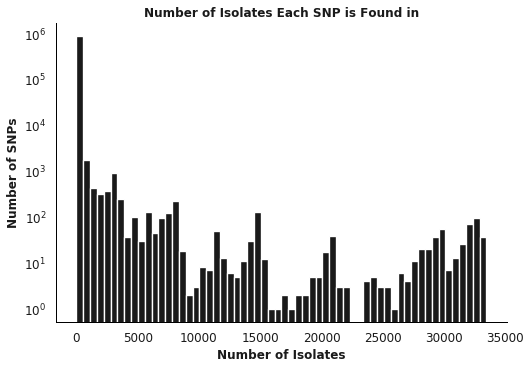

In [32]:
fig , ax = plt.subplots()

n , bins , patches = plt.hist(SNV_DF.num_isolates.astype(float) , bins = 60 , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=1.35)

plt.title('Number of Isolates Each SNP is Found in', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.xlabel('Number of Isolates', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.ylabel('Number of SNPs', fontweight = 'bold' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')
ax.set_yscale("log", nonposy='clip')

fig = plt.gcf()
fig.set_size_inches(7.5, 5.25)
fig.tight_layout()

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

#file_name = '/home/rv76/Farhat_Lab/Figures/Final_5/Scraping_rollingDB/Mean_Coverage_Distribution_across_all_isolates.pdf'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

#### How many SNP sites have at least *1* isolate with an alternate allele?

In [33]:
np.shape(SNV_DF[SNV_DF.num_isolates >= 1])

(878244, 4)

#### How many SNP sites have at least *2* isolates with an alternate allele?

In [34]:
np.shape(SNV_DF[SNV_DF.num_isolates >= 2])

(417738, 4)

#### How many SNP sites have at least *3* isolates with an alternate allele?

In [35]:
np.shape(SNV_DF[SNV_DF.num_isolates >= 3])

(254265, 4)

#### How many SNP sites have at least *4* isolates with an alternate allele?

In [36]:
np.shape(SNV_DF[SNV_DF.num_isolates >= 4])

(187622, 4)

#### How many SNP sites have at least *5* isolates with an alternate allele?

In [37]:
np.shape(SNV_DF[SNV_DF.num_isolates >= 5])

(146874, 4)

### Keep only SNVs in which the corresponding *Reference Position* has a SNV in $\ge$ 5 isolates

SNVs founds in only 1-4 isolate(s) are dropped

In [38]:
SNV_DF = SNV_DF[SNV_DF.num_isolates >= 5]

In [39]:
np.shape(SNV_DF)

(146874, 4)

In [40]:
SNV_DF.head()

,ref,alt,num_isolates,pos
2,A,[C],8,11
6,C,[G],19,29
7,A,"[C, G]",10,31
10,C,[T],5,48
11,G,[C],5,64


#### Re-Structure DataFrame to include only the Reference Position, Reference Allele and Alternate Allele(s)

In [41]:
SNV_annotation_DF = pd.DataFrame(index = range( 0 , np.shape(SNV_DF)[0] ) ) #index for each SNV
SNV_annotation_DF['pos'] = list(SNV_DF.pos) #H37Rv Reference Position
SNV_annotation_DF['ref'] = list(SNV_DF.ref) #reference allele
SNV_annotation_DF['alt'] = list(SNV_DF.alt) #alterante allele(s) list

In [42]:
np.shape(SNV_annotation_DF)

(146874, 3)

In [43]:
SNV_annotation_DF.head() #index = row indices of genotype matrix , 0 supports ref, 1 supports alt

,pos,ref,alt
0,11,A,[C]
1,29,C,[G]
2,31,A,"[C, G]"
3,48,C,[T]
4,64,G,[C]


#### This is the DataFrame which we'll use to extract SNVs of interest when iterating over all of the VCF files in rollingDB

Output Annotation for SNVs of interest in Genotypes folder

In [46]:
SNV_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/genotypes_SNP_annotation.pkl')

#### Create a text file with a single column of all Reference Positions that we're interested in based off of DF above. We will use this text file to subset the *full* VCF files to only the positions that Reference Positions that have a SNV in at least 2 isolates.

In [47]:
SNV_ref_positions = ['NC_000962.3\t' + ref_pos for ref_pos in list( SNV_annotation_DF.pos.astype(str) ) ]

#save each element as a new row in a text file
with open('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/ref_positions_to_select.txt', 'w') as f:
    for item in SNV_ref_positions:
        f.write("%s\n" % item)

####################################################################################################################################################################################

## [6] This section of the notebook submits jobs to subset Full VCFs to the 146,874 reference positions that have a SNV in $\ge 5$ isolates in rollingDB.

####################################################################################################################################################################################

In [89]:
import os
import pandas as pd
from slurmpy import Slurm
import numpy as np
import itertools
import shutil

Every isolate in the pool of **33,873** isolates in rollingDB had a reduced VCF file and a corresponding Full VCF file. We will subset each of these Full VCF files and create subset VCF files containing information for only the **146,874** reference positions that we're interested in.

In [90]:
isolate_id_series = pd.read_pickle( '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/genotypes_isolate_annotation.pkl' )

In [91]:
isolate_id_series.head()

0    SAMEA3558733
1    SAMN05575260
2    SAMN03648641
3    SAMN03647419
4    SAMEA3671418
dtype: object

In [92]:
len(isolate_id_series)

33873

#### Create directory for each isolate to store output for genotyping

In [93]:
for tag in isolate_id_series.values:

    #create directory to store subset VCF and genotypes for each isolate
    isolate_genotype_dir = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/Genotypes_per_isolate/' + tag
    if os.path.exists(isolate_genotype_dir):
        shutil.rmtree(isolate_genotype_dir)
        os.makedirs(isolate_genotype_dir)
    elif not os.path.exists(isolate_genotype_dir):
        os.makedirs(isolate_genotype_dir)

#### Subset VCF to reference positions of interest for isolates that had Full VCF files 

Create BASH scripts to extract VCFs of N isolates per job

In [94]:
N_isolates_per_job = 70

njobs = int( np.ceil( float( len( isolate_id_series ) ) / float(N_isolates_per_job) ) ) #number of jobs required if we split for every N isolates

In [95]:
print njobs

484


In [96]:
bash_scripts = []

#genomic data directory
rolling_DB_dir = '/n/data1/hms/dbmi/farhat/rollingDB/genomic_data/'

#split jobs up into tasks of N
for first_isolate_i_for_job in np.arange(0 , (njobs)*N_isolates_per_job , N_isolates_per_job):

    last_isolate_i_for_job = first_isolate_i_for_job + N_isolates_per_job
    
    commands_list = []
    commands_list.append( 'module load bcftools/1.9' ) #only need to load this once per job

    for isolate_i in range(first_isolate_i_for_job , last_isolate_i_for_job): 

        try:
            tag = isolate_id_series[isolate_i]
            zipped_VCF = rolling_DB_dir + tag + '/pilon/' + tag + '_full.vcf.gz'
            isolate_genotypes_dir = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/Genotypes_per_isolate/' + tag

            commands_list.append( 'cd {}'.format(isolate_genotypes_dir) )
            commands_list.append( 'time bcftools view {} -O b -o current.bcf'.format(zipped_VCF) )
            commands_list.append( 'bcftools index current.bcf' )
            commands_list.append( 'bcftools view current.bcf --regions-file /n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/ref_positions_to_select.txt -o {0}_ref_positions_for_genotyping.vcf -O v'.format(tag) )
            commands_list.append( 'rm current.bcf.csi current.bcf' )
            
        except KeyError: #applies only to the last job if it has < N isolates
            continue
        
    bash_scripts.append(commands_list)

#### Submit each job to O2

In [97]:
job_num = 1
for job_i_commands_list in bash_scripts:
    
    #append all commands in a single string to be submitted as a job
    VCF_extract_job = ''
    for command_i in job_i_commands_list:
        VCF_extract_job  = VCF_extract_job  + '\n' + command_i
    
    #directory where you want output + error files
    os.chdir('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/O2_SLURM_logs/VCF_refpos_for_genotyping_extraction/')

    job_name = 'VCF_' + str(job_num)

    s = Slurm(job_name , {'partition':'short' , 'n':'1' , 't':'0-12:00:00' , 'mem-per-cpu':'2G' , 'mail-type':'FAIL' , 'mail-user':'roger_vargas@g.harvard.edu'})

    #submits the job
    job_id = s.run(VCF_extract_job)

    print job_name
    job_num += 1

submitted: Submitted batch job 3318878


VCF_1


submitted: Submitted batch job 3318879


VCF_2


submitted: Submitted batch job 3318880


VCF_3


submitted: Submitted batch job 3318881


VCF_4


submitted: Submitted batch job 3318882


VCF_5


submitted: Submitted batch job 3318883


VCF_6


submitted: Submitted batch job 3318884
submitted: Submitted batch job 3318885


VCF_7
VCF_8


submitted: Submitted batch job 3318886
submitted: Submitted batch job 3318887


VCF_9
VCF_10


submitted: Submitted batch job 3318888
submitted: Submitted batch job 3318889
submitted: Submitted batch job 3318890


VCF_11
VCF_12
VCF_13


submitted: Submitted batch job 3318891
submitted: Submitted batch job 3318892


VCF_14
VCF_15


submitted: Submitted batch job 3318893


VCF_16


submitted: Submitted batch job 3318894
submitted: Submitted batch job 3318895


VCF_17
VCF_18


submitted: Submitted batch job 3318896


VCF_19


submitted: Submitted batch job 3318897
submitted: Submitted batch job 3318898


VCF_20
VCF_21


submitted: Submitted batch job 3318899


VCF_22


submitted: Submitted batch job 3318900


VCF_23


submitted: Submitted batch job 3318901


VCF_24


submitted: Submitted batch job 3318902
submitted: Submitted batch job 3318903


VCF_25
VCF_26


submitted: Submitted batch job 3318904


VCF_27


submitted: Submitted batch job 3318905


VCF_28


submitted: Submitted batch job 3318906


VCF_29


submitted: Submitted batch job 3318907


VCF_30


submitted: Submitted batch job 3318909
submitted: Submitted batch job 3318910


VCF_31
VCF_32


submitted: Submitted batch job 3318911
submitted: Submitted batch job 3318912


VCF_33
VCF_34


submitted: Submitted batch job 3318913
submitted: Submitted batch job 3318914


VCF_35
VCF_36


submitted: Submitted batch job 3318915


VCF_37


submitted: Submitted batch job 3318916


VCF_38


submitted: Submitted batch job 3318917
submitted: Submitted batch job 3318918


VCF_39
VCF_40


submitted: Submitted batch job 3318919


VCF_41


submitted: Submitted batch job 3318920


VCF_42


submitted: Submitted batch job 3318921


VCF_43


submitted: Submitted batch job 3318922
submitted: Submitted batch job 3318923


VCF_44
VCF_45


submitted: Submitted batch job 3318924


VCF_46


submitted: Submitted batch job 3318925


VCF_47


submitted: Submitted batch job 3318926


VCF_48


submitted: Submitted batch job 3318927


VCF_49


submitted: Submitted batch job 3318928


VCF_50


submitted: Submitted batch job 3318929
submitted: Submitted batch job 3318930


VCF_51
VCF_52


submitted: Submitted batch job 3318931
submitted: Submitted batch job 3318932
submitted: Submitted batch job 3318933


VCF_53
VCF_54
VCF_55


submitted: Submitted batch job 3318934


VCF_56


submitted: Submitted batch job 3318935
submitted: Submitted batch job 3318936


VCF_57
VCF_58


submitted: Submitted batch job 3318937
submitted: Submitted batch job 3318938


VCF_59
VCF_60


submitted: Submitted batch job 3318939


VCF_61


submitted: Submitted batch job 3318940
submitted: Submitted batch job 3318941
submitted: Submitted batch job 3318942


VCF_62
VCF_63
VCF_64


submitted: Submitted batch job 3318943
submitted: Submitted batch job 3318944
submitted: Submitted batch job 3318945


VCF_65
VCF_66
VCF_67


submitted: Submitted batch job 3318946
submitted: Submitted batch job 3318947
submitted: Submitted batch job 3318948


VCF_68
VCF_69
VCF_70


submitted: Submitted batch job 3318949
submitted: Submitted batch job 3318950
submitted: Submitted batch job 3318951


VCF_71
VCF_72
VCF_73


submitted: Submitted batch job 3318952


VCF_74


submitted: Submitted batch job 3318953
submitted: Submitted batch job 3318954


VCF_75
VCF_76


submitted: Submitted batch job 3318955
submitted: Submitted batch job 3318956
submitted: Submitted batch job 3318957


VCF_77
VCF_78
VCF_79


submitted: Submitted batch job 3318958


VCF_80


submitted: Submitted batch job 3318959
submitted: Submitted batch job 3318960
submitted: Submitted batch job 3318961


VCF_81
VCF_82
VCF_83


submitted: Submitted batch job 3318962
submitted: Submitted batch job 3318963
submitted: Submitted batch job 3318964


VCF_84
VCF_85
VCF_86


submitted: Submitted batch job 3318965
submitted: Submitted batch job 3318966
submitted: Submitted batch job 3318967


VCF_87
VCF_88
VCF_89


submitted: Submitted batch job 3318968
submitted: Submitted batch job 3318969
submitted: Submitted batch job 3318970


VCF_90
VCF_91
VCF_92


submitted: Submitted batch job 3318971
submitted: Submitted batch job 3318972


VCF_93
VCF_94


submitted: Submitted batch job 3318973


VCF_95


submitted: Submitted batch job 3318974


VCF_96


submitted: Submitted batch job 3318975


VCF_97


submitted: Submitted batch job 3318976
submitted: Submitted batch job 3318977


VCF_98
VCF_99


submitted: Submitted batch job 3318978
submitted: Submitted batch job 3318979
submitted: Submitted batch job 3318980


VCF_100
VCF_101
VCF_102


submitted: Submitted batch job 3318981
submitted: Submitted batch job 3318982
submitted: Submitted batch job 3318983


VCF_103
VCF_104
VCF_105


submitted: Submitted batch job 3318984
submitted: Submitted batch job 3318985
submitted: Submitted batch job 3318986


VCF_106
VCF_107
VCF_108


submitted: Submitted batch job 3318987


VCF_109


submitted: Submitted batch job 3318988
submitted: Submitted batch job 3318989


VCF_110
VCF_111


submitted: Submitted batch job 3318990
submitted: Submitted batch job 3318991


VCF_112
VCF_113


submitted: Submitted batch job 3318992
submitted: Submitted batch job 3318993
submitted: Submitted batch job 3318994


VCF_114
VCF_115
VCF_116


submitted: Submitted batch job 3318995


VCF_117


submitted: Submitted batch job 3318996


VCF_118


submitted: Submitted batch job 3318997
submitted: Submitted batch job 3318998
submitted: Submitted batch job 3318999


VCF_119
VCF_120
VCF_121


submitted: Submitted batch job 3319000


VCF_122


submitted: Submitted batch job 3319001
submitted: Submitted batch job 3319002
submitted: Submitted batch job 3319003


VCF_123
VCF_124
VCF_125


submitted: Submitted batch job 3319004


VCF_126


submitted: Submitted batch job 3319005


VCF_127


submitted: Submitted batch job 3319006
submitted: Submitted batch job 3319007
submitted: Submitted batch job 3319008


VCF_128
VCF_129
VCF_130


submitted: Submitted batch job 3319009
submitted: Submitted batch job 3319010


VCF_131
VCF_132


submitted: Submitted batch job 3319011
submitted: Submitted batch job 3319012


VCF_133
VCF_134


submitted: Submitted batch job 3319013
submitted: Submitted batch job 3319014
submitted: Submitted batch job 3319015


VCF_135
VCF_136
VCF_137


submitted: Submitted batch job 3319016
submitted: Submitted batch job 3319017
submitted: Submitted batch job 3319018


VCF_138
VCF_139
VCF_140


submitted: Submitted batch job 3319019


VCF_141


submitted: Submitted batch job 3319020
submitted: Submitted batch job 3319021
submitted: Submitted batch job 3319022


VCF_142
VCF_143
VCF_144


submitted: Submitted batch job 3319023
submitted: Submitted batch job 3319024


VCF_145
VCF_146


submitted: Submitted batch job 3319025


VCF_147


submitted: Submitted batch job 3319026


VCF_148


submitted: Submitted batch job 3319027
submitted: Submitted batch job 3319028


VCF_149
VCF_150


submitted: Submitted batch job 3319029
submitted: Submitted batch job 3319030


VCF_151
VCF_152


submitted: Submitted batch job 3319031
submitted: Submitted batch job 3319032
submitted: Submitted batch job 3319033


VCF_153
VCF_154
VCF_155


submitted: Submitted batch job 3319034
submitted: Submitted batch job 3319035


VCF_156
VCF_157


submitted: Submitted batch job 3319036


VCF_158


submitted: Submitted batch job 3319037
submitted: Submitted batch job 3319038


VCF_159
VCF_160


submitted: Submitted batch job 3319039
submitted: Submitted batch job 3319040


VCF_161
VCF_162


submitted: Submitted batch job 3319041


VCF_163


submitted: Submitted batch job 3319042
submitted: Submitted batch job 3319043


VCF_164
VCF_165


submitted: Submitted batch job 3319044


VCF_166


submitted: Submitted batch job 3319045


VCF_167


submitted: Submitted batch job 3319046


VCF_168


submitted: Submitted batch job 3319047


VCF_169


submitted: Submitted batch job 3319048


VCF_170


submitted: Submitted batch job 3319049


VCF_171


submitted: Submitted batch job 3319050
submitted: Submitted batch job 3319051


VCF_172
VCF_173


submitted: Submitted batch job 3319052


VCF_174


submitted: Submitted batch job 3319053


VCF_175


submitted: Submitted batch job 3319054


VCF_176


submitted: Submitted batch job 3319055


VCF_177


submitted: Submitted batch job 3319056
submitted: Submitted batch job 3319057


VCF_178
VCF_179


submitted: Submitted batch job 3319058


VCF_180


submitted: Submitted batch job 3319059


VCF_181


submitted: Submitted batch job 3319060


VCF_182


submitted: Submitted batch job 3319061


VCF_183


submitted: Submitted batch job 3319062


VCF_184


submitted: Submitted batch job 3319063


VCF_185


submitted: Submitted batch job 3319064


VCF_186


submitted: Submitted batch job 3319065
submitted: Submitted batch job 3319066


VCF_187
VCF_188


submitted: Submitted batch job 3319067


VCF_189


submitted: Submitted batch job 3319068


VCF_190


submitted: Submitted batch job 3319069


VCF_191


submitted: Submitted batch job 3319070


VCF_192


submitted: Submitted batch job 3319071


VCF_193


submitted: Submitted batch job 3319072


VCF_194


submitted: Submitted batch job 3319073


VCF_195


submitted: Submitted batch job 3319074
submitted: Submitted batch job 3319075


VCF_196
VCF_197


submitted: Submitted batch job 3319076


VCF_198


submitted: Submitted batch job 3319077


VCF_199


submitted: Submitted batch job 3319078


VCF_200


submitted: Submitted batch job 3319079


VCF_201


submitted: Submitted batch job 3319080


VCF_202


submitted: Submitted batch job 3319081


VCF_203


submitted: Submitted batch job 3319082
submitted: Submitted batch job 3319083


VCF_204
VCF_205


submitted: Submitted batch job 3319084
submitted: Submitted batch job 3319085


VCF_206
VCF_207


submitted: Submitted batch job 3319086


VCF_208


submitted: Submitted batch job 3319087


VCF_209


submitted: Submitted batch job 3319088


VCF_210


submitted: Submitted batch job 3319089


VCF_211


submitted: Submitted batch job 3319090


VCF_212


submitted: Submitted batch job 3319091


VCF_213


submitted: Submitted batch job 3319092


VCF_214


submitted: Submitted batch job 3319093


VCF_215


submitted: Submitted batch job 3319094
submitted: Submitted batch job 3319095


VCF_216
VCF_217


submitted: Submitted batch job 3319096
submitted: Submitted batch job 3319097
submitted: Submitted batch job 3319098


VCF_218
VCF_219
VCF_220


submitted: Submitted batch job 3319099
submitted: Submitted batch job 3319100


VCF_221
VCF_222


submitted: Submitted batch job 3319101
submitted: Submitted batch job 3319102


VCF_223
VCF_224


submitted: Submitted batch job 3319103
submitted: Submitted batch job 3319104
submitted: Submitted batch job 3319105


VCF_225
VCF_226
VCF_227


submitted: Submitted batch job 3319106
submitted: Submitted batch job 3319107


VCF_228
VCF_229


submitted: Submitted batch job 3319108
submitted: Submitted batch job 3319109
submitted: Submitted batch job 3319110


VCF_230
VCF_231
VCF_232


submitted: Submitted batch job 3319111
submitted: Submitted batch job 3319112


VCF_233
VCF_234


submitted: Submitted batch job 3319113


VCF_235


submitted: Submitted batch job 3319114
submitted: Submitted batch job 3319115
submitted: Submitted batch job 3319116


VCF_236
VCF_237
VCF_238


submitted: Submitted batch job 3319117
submitted: Submitted batch job 3319118
submitted: Submitted batch job 3319119


VCF_239
VCF_240
VCF_241


submitted: Submitted batch job 3319120
submitted: Submitted batch job 3319121
submitted: Submitted batch job 3319122


VCF_242
VCF_243
VCF_244


submitted: Submitted batch job 3319123
submitted: Submitted batch job 3319124
submitted: Submitted batch job 3319125


VCF_245
VCF_246
VCF_247


submitted: Submitted batch job 3319126
submitted: Submitted batch job 3319127
submitted: Submitted batch job 3319128


VCF_248
VCF_249
VCF_250


submitted: Submitted batch job 3319129
submitted: Submitted batch job 3319130
submitted: Submitted batch job 3319131


VCF_251
VCF_252
VCF_253


submitted: Submitted batch job 3319132
submitted: Submitted batch job 3319133
submitted: Submitted batch job 3319134


VCF_254
VCF_255
VCF_256


submitted: Submitted batch job 3319135
submitted: Submitted batch job 3319136
submitted: Submitted batch job 3319137


VCF_257
VCF_258
VCF_259


submitted: Submitted batch job 3319138


VCF_260


submitted: Submitted batch job 3319139


VCF_261


submitted: Submitted batch job 3319140


VCF_262


submitted: Submitted batch job 3319141


VCF_263


submitted: Submitted batch job 3319142
submitted: Submitted batch job 3319143
submitted: Submitted batch job 3319144


VCF_264
VCF_265
VCF_266


submitted: Submitted batch job 3319145


VCF_267


submitted: Submitted batch job 3319146
submitted: Submitted batch job 3319147
submitted: Submitted batch job 3319148


VCF_268
VCF_269
VCF_270


submitted: Submitted batch job 3319149


VCF_271


submitted: Submitted batch job 3319150


VCF_272


submitted: Submitted batch job 3319151


VCF_273


submitted: Submitted batch job 3319152


VCF_274


submitted: Submitted batch job 3319154


VCF_275


submitted: Submitted batch job 3319164


VCF_276


submitted: Submitted batch job 3319165
submitted: Submitted batch job 3319166
submitted: Submitted batch job 3319167


VCF_277
VCF_278
VCF_279


submitted: Submitted batch job 3319168
submitted: Submitted batch job 3319169
submitted: Submitted batch job 3319170


VCF_280
VCF_281
VCF_282


submitted: Submitted batch job 3319171
submitted: Submitted batch job 3319172


VCF_283
VCF_284


submitted: Submitted batch job 3319173
submitted: Submitted batch job 3319174
submitted: Submitted batch job 3319175


VCF_285
VCF_286
VCF_287


submitted: Submitted batch job 3319176
submitted: Submitted batch job 3319177
submitted: Submitted batch job 3319178


VCF_288
VCF_289
VCF_290


submitted: Submitted batch job 3319179


VCF_291


submitted: Submitted batch job 3319180
submitted: Submitted batch job 3319181
submitted: Submitted batch job 3319182


VCF_292
VCF_293
VCF_294


submitted: Submitted batch job 3319183
submitted: Submitted batch job 3319184
submitted: Submitted batch job 3319185


VCF_295
VCF_296
VCF_297


submitted: Submitted batch job 3319186
submitted: Submitted batch job 3319187


VCF_298
VCF_299


submitted: Submitted batch job 3319188
submitted: Submitted batch job 3319189
submitted: Submitted batch job 3319190


VCF_300
VCF_301
VCF_302


submitted: Submitted batch job 3319191
submitted: Submitted batch job 3319192
submitted: Submitted batch job 3319193


VCF_303
VCF_304
VCF_305


submitted: Submitted batch job 3319194


VCF_306


submitted: Submitted batch job 3319195
submitted: Submitted batch job 3319196


VCF_307
VCF_308


submitted: Submitted batch job 3319197
submitted: Submitted batch job 3319198


VCF_309
VCF_310


submitted: Submitted batch job 3319199
submitted: Submitted batch job 3319200


VCF_311
VCF_312


submitted: Submitted batch job 3319201


VCF_313


submitted: Submitted batch job 3319202
submitted: Submitted batch job 3319203


VCF_314
VCF_315


submitted: Submitted batch job 3319204


VCF_316


submitted: Submitted batch job 3319205
submitted: Submitted batch job 3319206


VCF_317
VCF_318


submitted: Submitted batch job 3319207


VCF_319


submitted: Submitted batch job 3319208
submitted: Submitted batch job 3319209


VCF_320
VCF_321


submitted: Submitted batch job 3319210


VCF_322


submitted: Submitted batch job 3319211
submitted: Submitted batch job 3319212


VCF_323
VCF_324


submitted: Submitted batch job 3319213


VCF_325


submitted: Submitted batch job 3319214


VCF_326


submitted: Submitted batch job 3319215
submitted: Submitted batch job 3319216


VCF_327
VCF_328


submitted: Submitted batch job 3319217


VCF_329


submitted: Submitted batch job 3319218


VCF_330


submitted: Submitted batch job 3319219


VCF_331


submitted: Submitted batch job 3319220


VCF_332


submitted: Submitted batch job 3319221


VCF_333


submitted: Submitted batch job 3319222


VCF_334


submitted: Submitted batch job 3319223


VCF_335


submitted: Submitted batch job 3319224


VCF_336


submitted: Submitted batch job 3319225


VCF_337


submitted: Submitted batch job 3319226


VCF_338


submitted: Submitted batch job 3319227


VCF_339


submitted: Submitted batch job 3319228


VCF_340


submitted: Submitted batch job 3319229


VCF_341


submitted: Submitted batch job 3319230


VCF_342


submitted: Submitted batch job 3319231


VCF_343


submitted: Submitted batch job 3319232


VCF_344


submitted: Submitted batch job 3319233


VCF_345


submitted: Submitted batch job 3319234


VCF_346


submitted: Submitted batch job 3319235


VCF_347


submitted: Submitted batch job 3319236
submitted: Submitted batch job 3319237
submitted: Submitted batch job 3319238


VCF_348
VCF_349
VCF_350


submitted: Submitted batch job 3319239
submitted: Submitted batch job 3319240


VCF_351
VCF_352


submitted: Submitted batch job 3319241
submitted: Submitted batch job 3319242
submitted: Submitted batch job 3319243


VCF_353
VCF_354
VCF_355


submitted: Submitted batch job 3319244
submitted: Submitted batch job 3319245
submitted: Submitted batch job 3319246


VCF_356
VCF_357
VCF_358


submitted: Submitted batch job 3319247
submitted: Submitted batch job 3319248
submitted: Submitted batch job 3319249


VCF_359
VCF_360
VCF_361


submitted: Submitted batch job 3319250
submitted: Submitted batch job 3319251
submitted: Submitted batch job 3319252


VCF_362
VCF_363
VCF_364


submitted: Submitted batch job 3319253
submitted: Submitted batch job 3319254
submitted: Submitted batch job 3319255


VCF_365
VCF_366
VCF_367


submitted: Submitted batch job 3319256
submitted: Submitted batch job 3319257


VCF_368
VCF_369


submitted: Submitted batch job 3319258


VCF_370


submitted: Submitted batch job 3319259


VCF_371


submitted: Submitted batch job 3319260
submitted: Submitted batch job 3319261
submitted: Submitted batch job 3319262


VCF_372
VCF_373
VCF_374


submitted: Submitted batch job 3319263
submitted: Submitted batch job 3319264
submitted: Submitted batch job 3319265


VCF_375
VCF_376
VCF_377


submitted: Submitted batch job 3319266
submitted: Submitted batch job 3319267


VCF_378
VCF_379


submitted: Submitted batch job 3319268
submitted: Submitted batch job 3319269
submitted: Submitted batch job 3319270


VCF_380
VCF_381
VCF_382


submitted: Submitted batch job 3319271
submitted: Submitted batch job 3319272
submitted: Submitted batch job 3319273


VCF_383
VCF_384
VCF_385


submitted: Submitted batch job 3319274
submitted: Submitted batch job 3319275


VCF_386
VCF_387


submitted: Submitted batch job 3319276
submitted: Submitted batch job 3319277
submitted: Submitted batch job 3319278


VCF_388
VCF_389
VCF_390


submitted: Submitted batch job 3319279
submitted: Submitted batch job 3319280
submitted: Submitted batch job 3319281


VCF_391
VCF_392
VCF_393


submitted: Submitted batch job 3319282
submitted: Submitted batch job 3319283


VCF_394
VCF_395


submitted: Submitted batch job 3319284
submitted: Submitted batch job 3319285
submitted: Submitted batch job 3319286


VCF_396
VCF_397
VCF_398


submitted: Submitted batch job 3319287


VCF_399


submitted: Submitted batch job 3319288


VCF_400


submitted: Submitted batch job 3319289


VCF_401


submitted: Submitted batch job 3319290


VCF_402


submitted: Submitted batch job 3319291
submitted: Submitted batch job 3319292
submitted: Submitted batch job 3319293


VCF_403
VCF_404
VCF_405


submitted: Submitted batch job 3319294
submitted: Submitted batch job 3319295
submitted: Submitted batch job 3319296


VCF_406
VCF_407
VCF_408


submitted: Submitted batch job 3319297
submitted: Submitted batch job 3319298


VCF_409
VCF_410


submitted: Submitted batch job 3319299
submitted: Submitted batch job 3319300
submitted: Submitted batch job 3319301


VCF_411
VCF_412
VCF_413


submitted: Submitted batch job 3319302
submitted: Submitted batch job 3319303
submitted: Submitted batch job 3319304


VCF_414
VCF_415
VCF_416


submitted: Submitted batch job 3319305
submitted: Submitted batch job 3319306


VCF_417
VCF_418


submitted: Submitted batch job 3319308
submitted: Submitted batch job 3319309


VCF_419
VCF_420


submitted: Submitted batch job 3319310
submitted: Submitted batch job 3319311


VCF_421
VCF_422


submitted: Submitted batch job 3319312
submitted: Submitted batch job 3319313
submitted: Submitted batch job 3319314


VCF_423
VCF_424
VCF_425


submitted: Submitted batch job 3319315
submitted: Submitted batch job 3319316
submitted: Submitted batch job 3319317


VCF_426
VCF_427
VCF_428


submitted: Submitted batch job 3319318


VCF_429


submitted: Submitted batch job 3319319


VCF_430


submitted: Submitted batch job 3319320
submitted: Submitted batch job 3319321


VCF_431
VCF_432


submitted: Submitted batch job 3319322


VCF_433


submitted: Submitted batch job 3319323
submitted: Submitted batch job 3319324
submitted: Submitted batch job 3319325


VCF_434
VCF_435
VCF_436


submitted: Submitted batch job 3319326
submitted: Submitted batch job 3319327
submitted: Submitted batch job 3319328


VCF_437
VCF_438
VCF_439


submitted: Submitted batch job 3319329
submitted: Submitted batch job 3319330
submitted: Submitted batch job 3319331


VCF_440
VCF_441
VCF_442


submitted: Submitted batch job 3319332
submitted: Submitted batch job 3319333
submitted: Submitted batch job 3319334


VCF_443
VCF_444
VCF_445


submitted: Submitted batch job 3319335
submitted: Submitted batch job 3319336


VCF_446
VCF_447


submitted: Submitted batch job 3319337
submitted: Submitted batch job 3319338
submitted: Submitted batch job 3319339


VCF_448
VCF_449
VCF_450


submitted: Submitted batch job 3319340
submitted: Submitted batch job 3319341
submitted: Submitted batch job 3319342


VCF_451
VCF_452
VCF_453


submitted: Submitted batch job 3319343


VCF_454


submitted: Submitted batch job 3319344
submitted: Submitted batch job 3319345
submitted: Submitted batch job 3319346


VCF_455
VCF_456
VCF_457


submitted: Submitted batch job 3319347


VCF_458


submitted: Submitted batch job 3319348
submitted: Submitted batch job 3319349


VCF_459
VCF_460


submitted: Submitted batch job 3319350


VCF_461


submitted: Submitted batch job 3319351
submitted: Submitted batch job 3319352
submitted: Submitted batch job 3319353


VCF_462
VCF_463
VCF_464


submitted: Submitted batch job 3319354


VCF_465


submitted: Submitted batch job 3319355
submitted: Submitted batch job 3319356
submitted: Submitted batch job 3319357


VCF_466
VCF_467
VCF_468


submitted: Submitted batch job 3319358
submitted: Submitted batch job 3319359


VCF_469
VCF_470


submitted: Submitted batch job 3319360


VCF_471


submitted: Submitted batch job 3319361
submitted: Submitted batch job 3319362


VCF_472
VCF_473


submitted: Submitted batch job 3319363


VCF_474


submitted: Submitted batch job 3319364
submitted: Submitted batch job 3319365


VCF_475
VCF_476


submitted: Submitted batch job 3319366


VCF_477


submitted: Submitted batch job 3319367


VCF_478


submitted: Submitted batch job 3319368


VCF_479


submitted: Submitted batch job 3319369
submitted: Submitted batch job 3319370


VCF_480
VCF_481


submitted: Submitted batch job 3319371
submitted: Submitted batch job 3319372


VCF_482
VCF_483
VCF_484


submitted: Submitted batch job 3319373


####################################################################################################################################################################################

### Run any remaining isolates through VCF subsetting procedure that don't have a corresponding subset VCF

####################################################################################################################################################################################

In [34]:
import os
import pandas as pd
from slurmpy import Slurm
import numpy as np
import itertools
import shutil

In [35]:
isolate_id_series = pd.read_pickle( '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/genotypes_isolate_annotation.pkl' )

__Check Progress of Jobs:__ Isolates that need to have Full VCF >> Subset VCF for Reference Positions of Interest

In [36]:
isolate_ids_to_run_VCF_extraction = []
isolate_ids_completed = []

for tag in isolate_id_series.values:

    #create directory to store subset VCF and genotypes for each isolate
    isolate_genotype_dir = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/Genotypes_per_isolate/' + tag
    
    #current.bcf file
    current_bcf_path = isolate_genotype_dir + '/current.bcf'
    
    #current.bcf.csi file
    current_bcf_csi_path = isolate_genotype_dir + '/current.bcf.csi'
    
    #subset VCF file
    subset_VCF_path = isolate_genotype_dir + '/' + tag + '_ref_positions_for_genotyping.vcf'
    
    #check for the existence of a VCF file, if TRUE job has either started or completed
    if os.path.exists(subset_VCF_path):
        
        #check to see if intermediary files exist, if they do then VCF subset task hasn't completed
        if os.path.exists(current_bcf_path) or os.path.exists(current_bcf_csi_path):
            
            #remove files to start task over
            ## os.remove(current_bcf_path)
            ## os.remove(current_bcf_csi_path)
            ## os.remove(subset_VCF_path)
            
            isolate_ids_to_run_VCF_extraction.append(tag)
            
        #VCF exists, intermediary files gone so task finished
        else: 
            
            isolate_ids_completed.append(tag)
            
    #VCF file doesn't exist, task never started
    else:
        
        isolate_ids_to_run_VCF_extraction.append(tag)

In [37]:
len(isolate_ids_completed)

33873

In [38]:
len(isolate_ids_to_run_VCF_extraction)

0

##### Subset VCF to reference positions of interest for isolates that had Full VCF files 

In [13]:
isolate_id_series = pd.Series(isolate_ids_to_run_VCF_extraction)

Create BASH scripts to extract VCFs of N isolates per job

In [14]:
N_isolates_per_job = 65

njobs = int( np.ceil( float( len( isolate_id_series ) ) / float(N_isolates_per_job) ) ) #number of jobs required if we split for every N isolates

In [15]:
print njobs

114


In [16]:
bash_scripts = []

#genomic data directory
rolling_DB_dir = '/n/data1/hms/dbmi/farhat/rollingDB/genomic_data/'

#split jobs up into tasks of N
for first_isolate_i_for_job in np.arange(0 , (njobs)*N_isolates_per_job , N_isolates_per_job):

    last_isolate_i_for_job = first_isolate_i_for_job + N_isolates_per_job
    
    commands_list = []
    commands_list.append( 'module load bcftools/1.9' ) #only need to load this once per job

    for isolate_i in range(first_isolate_i_for_job , last_isolate_i_for_job): 

        try:
            tag = isolate_id_series[isolate_i]
            zipped_VCF = rolling_DB_dir + tag + '/pilon/' + tag + '_full.vcf.gz'
            isolate_genotypes_dir = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/Genotypes_per_isolate/' + tag

            commands_list.append( 'cd {}'.format(isolate_genotypes_dir) )
            commands_list.append( 'time bcftools view {} -O b -o current.bcf'.format(zipped_VCF) )
            commands_list.append( 'bcftools index current.bcf' )
            commands_list.append( 'bcftools view current.bcf --regions-file /n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/ref_positions_to_select.txt -o {0}_ref_positions_for_genotyping.vcf -O v'.format(tag) )
            commands_list.append( 'rm current.bcf.csi current.bcf' )
            
        except KeyError: #applies only to the last job if it has < N isolates
            continue
        
    bash_scripts.append(commands_list)

#### Submit each job to O2

In [17]:
job_num = 1
for job_i_commands_list in bash_scripts:
    
    #append all commands in a single string to be submitted as a job
    VCF_extract_job = ''
    for command_i in job_i_commands_list:
        VCF_extract_job  = VCF_extract_job  + '\n' + command_i
    
    #directory where you want output + error files
    os.chdir('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/O2_SLURM_logs/VCF_refpos_for_genotyping_extraction/')

    job_name = 'VCF_' + str(job_num)

    s = Slurm(job_name , {'partition':'short' , 'n':'1' , 't':'0-12:00:00' , 'mem-per-cpu':'2G' , 'mail-type':'FAIL' , 'mail-user':'roger_vargas@g.harvard.edu'})

    #submits the job
    job_id = s.run(VCF_extract_job)

    print job_name
    job_num += 1

submitted: Submitted batch job 3589690
submitted: Submitted batch job 3589692


VCF_1
VCF_2


submitted: Submitted batch job 3589694
submitted: Submitted batch job 3589695


VCF_3
VCF_4


submitted: Submitted batch job 3589696
submitted: Submitted batch job 3589697


VCF_5
VCF_6


submitted: Submitted batch job 3589698
submitted: Submitted batch job 3589701
submitted: Submitted batch job 3589702


VCF_7
VCF_8
VCF_9


submitted: Submitted batch job 3589703


VCF_10


submitted: Submitted batch job 3589704
submitted: Submitted batch job 3589706


VCF_11
VCF_12


submitted: Submitted batch job 3589708
submitted: Submitted batch job 3589710


VCF_13
VCF_14


submitted: Submitted batch job 3589713
submitted: Submitted batch job 3589715


VCF_15
VCF_16


submitted: Submitted batch job 3589718


VCF_17


submitted: Submitted batch job 3589720


VCF_18


submitted: Submitted batch job 3589724
submitted: Submitted batch job 3589725
submitted: Submitted batch job 3589726


VCF_19
VCF_20
VCF_21


submitted: Submitted batch job 3589728
submitted: Submitted batch job 3589731
submitted: Submitted batch job 3589732


VCF_22
VCF_23
VCF_24


submitted: Submitted batch job 3589733
submitted: Submitted batch job 3589734
submitted: Submitted batch job 3589735


VCF_25
VCF_26
VCF_27


submitted: Submitted batch job 3589736
submitted: Submitted batch job 3589737


VCF_28
VCF_29


submitted: Submitted batch job 3589739
submitted: Submitted batch job 3589741
submitted: Submitted batch job 3589742


VCF_30
VCF_31
VCF_32


submitted: Submitted batch job 3589744
submitted: Submitted batch job 3589745
submitted: Submitted batch job 3589746


VCF_33
VCF_34
VCF_35


submitted: Submitted batch job 3589747
submitted: Submitted batch job 3589748
submitted: Submitted batch job 3589749
submitted: Submitted batch job 3589751


VCF_36
VCF_37
VCF_38
VCF_39


submitted: Submitted batch job 3589752


VCF_40


submitted: Submitted batch job 3589753
submitted: Submitted batch job 3589756
submitted: Submitted batch job 3589757


VCF_41
VCF_42
VCF_43


submitted: Submitted batch job 3589758
submitted: Submitted batch job 3589760
submitted: Submitted batch job 3589762


VCF_44
VCF_45
VCF_46


submitted: Submitted batch job 3589764
submitted: Submitted batch job 3589766


VCF_47
VCF_48


submitted: Submitted batch job 3589767
submitted: Submitted batch job 3589769
submitted: Submitted batch job 3589771


VCF_49
VCF_50
VCF_51


submitted: Submitted batch job 3589773
submitted: Submitted batch job 3589775
submitted: Submitted batch job 3589777
submitted: Submitted batch job 3589778


VCF_52
VCF_53
VCF_54
VCF_55


submitted: Submitted batch job 3589779
submitted: Submitted batch job 3589780


VCF_56
VCF_57


submitted: Submitted batch job 3589782


VCF_58


submitted: Submitted batch job 3589783
submitted: Submitted batch job 3589786
submitted: Submitted batch job 3589787


VCF_59
VCF_60
VCF_61


submitted: Submitted batch job 3589790
submitted: Submitted batch job 3589793


VCF_62
VCF_63


submitted: Submitted batch job 3589794
submitted: Submitted batch job 3589795
submitted: Submitted batch job 3589796


VCF_64
VCF_65
VCF_66


submitted: Submitted batch job 3589797
submitted: Submitted batch job 3589798


VCF_67
VCF_68


submitted: Submitted batch job 3589799
submitted: Submitted batch job 3589802
submitted: Submitted batch job 3589803


VCF_69
VCF_70
VCF_71


submitted: Submitted batch job 3589804
submitted: Submitted batch job 3589805
submitted: Submitted batch job 3589806
submitted: Submitted batch job 3589808


VCF_72
VCF_73
VCF_74
VCF_75


submitted: Submitted batch job 3589809
submitted: Submitted batch job 3589810
submitted: Submitted batch job 3589811
submitted: Submitted batch job 3589812


VCF_76
VCF_77
VCF_78
VCF_79


submitted: Submitted batch job 3589813
submitted: Submitted batch job 3589814
submitted: Submitted batch job 3589816


VCF_80
VCF_81
VCF_82


submitted: Submitted batch job 3589817
submitted: Submitted batch job 3589820
submitted: Submitted batch job 3589821


VCF_83
VCF_84
VCF_85


submitted: Submitted batch job 3589822
submitted: Submitted batch job 3589823
submitted: Submitted batch job 3589826


VCF_86
VCF_87
VCF_88


submitted: Submitted batch job 3589827


VCF_89


submitted: Submitted batch job 3589830


VCF_90


submitted: Submitted batch job 3589833
submitted: Submitted batch job 3589834


VCF_91
VCF_92


submitted: Submitted batch job 3589837
submitted: Submitted batch job 3589838


VCF_93
VCF_94


submitted: Submitted batch job 3589840


VCF_95


submitted: Submitted batch job 3589841


VCF_96


submitted: Submitted batch job 3589842


VCF_97


submitted: Submitted batch job 3589845
submitted: Submitted batch job 3589848


VCF_98
VCF_99


submitted: Submitted batch job 3589849
submitted: Submitted batch job 3589850
submitted: Submitted batch job 3589851


VCF_100
VCF_101
VCF_102


submitted: Submitted batch job 3589852
submitted: Submitted batch job 3589853
submitted: Submitted batch job 3589855


VCF_103
VCF_104
VCF_105


submitted: Submitted batch job 3589856
submitted: Submitted batch job 3589857


VCF_106
VCF_107


submitted: Submitted batch job 3589859


VCF_108


submitted: Submitted batch job 3589862
submitted: Submitted batch job 3589863
submitted: Submitted batch job 3589864
submitted: Submitted batch job 3589865


VCF_109
VCF_110
VCF_111
VCF_112
VCF_113
VCF_114


submitted: Submitted batch job 3589866
submitted: Submitted batch job 3589867


####################################################################################################################################################################################

## [7] This section of the notebook prepares the script that iterates over all of the VCF files in rollingDB and outputs a genotype vector.

####################################################################################################################################################################################

In [18]:
import vcf
import os
import pandas as pd
import numpy as np

In [19]:
isolate_ID = 'Peru4988' #INPUT - isolate ID

#### Load SNV-Index annotation (for indexing genotypes)

In [20]:
SNV_annotation_DF = pd.read_pickle( '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/genotypes_SNP_annotation.pkl' )

In [21]:
SNV_annotation_DF.head()

,pos,ref,alt
0,11,A,[C]
1,29,C,[G]
2,31,A,"[C, G]"
3,48,C,[T]
4,64,G,[C]


#### Convert SNV annotation into dictionaries with keys = ROW indices of genotype array

In [22]:
#keys: H37Rv Reference Position , values: Genotype Row Index
ref_pos_dict = dict( zip( list(SNV_annotation_DF.pos) , list(SNV_annotation_DF.index) ) )

#### Construct 'skeleton' Numpy Array that will store the supported base for all Reference Positions of interest for a single isolate in rollingDB

- **0** for _A_
- **1** for _C_
- **2** for _G_
- **3** for _T_
- **9** for Bad Quality SNV calls

In [23]:
#number of Reference Positions we're interested in (where High Quality SNV calls were made)
number_of_SNVs = len(ref_pos_dict.keys()) 

In [24]:
number_of_SNVs

146874

#### In constructing the Genotype Vector, we're going to iterate through all Reference Positions of interest and find the supported base from the VCF file for each position

In [25]:
#create an empty numpy array to store genotypes
genotypes_array = np.full(number_of_SNVs , 9 , dtype = int)

In [26]:
genotypes_array

array([9, 9, 9, ..., 9, 9, 9])

In [27]:
np.shape(genotypes_array)

(146874,)

### Iterate through the subset VCF file corresponding to the isolate in rollingDB and fill in genotypes vector

In [28]:
#genomic data directory
VCF_genotypes_dir = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/Genotypes_per_isolate/'

#directory that stores files for each sequenced isolate
directory_for_sequenced_isolate = VCF_genotypes_dir + isolate_ID + '/'

#position-base dictionaries (order of output in Pilon)
base_order = {0:'A' , 1:'C' , 2:'G', 3:'T'}
base_order_r = {'A':0 , 'C':1 , 'G':2 , 'T':3}

#load in VCF file if one was found
vcf_reader = vcf.Reader( open(directory_for_sequenced_isolate + isolate_ID + '_ref_positions_for_genotyping.vcf' , 'r') )

#iterate through each Variant Call 
for record in vcf_reader:
    
    #check to see if variant is SNP (length of Reference Allele is 1 base and there's only 1 alternate allele and length of alternate allele is 1 base is alternate allele exists)
    if (len(record.REF) == 1) and (len(record.ALT) == 1) and ( (record.ALT[0] == None) or (len(str(record.ALT[0])) == 1) ):

        #check to see if the call is a PASS by Pilon
        if record.FILTER == []:

            ##### Retrieve Relevant information for filtering quality of Base Call #####
            # Mean Base Quality @ locus
            BQ = record.INFO['BQ']
            # Mean Mapping Quality @ locus
            MQ = record.INFO['MQ']
            # Number of Reads w/ Deletion 
            DC = record.INFO['DC']
            # Number of Reads w/ Insertion
            IC = record.INFO['IC']
            # Depth of Valid Reads in Pileup
            VD = record.INFO['DP']

            ### Filtering Criteria
            #---> Mean Base Quality > 20
            #---> Mean Mapping Quality > 30
            #---> No Reads Supporting Insertions
            #---> No Reads Supporting Deletions
            #---> Number of High Quality Reads >= 25
            if (BQ > 20) and (MQ > 30) and (DC == 0) and (IC == 0) and (VD >= 25): 

                # Quality-Percentage - Percentage of As, Cs, Gs, Ts weighted by Q & MQ at locus
                QP = record.INFO['QP']

                if (sum(np.array(QP) >= 90) == 1): #1 Allele is supported by at least 90% of the reads, store information for this Base Call

                    #create a Boolean list for the Bases that have at least 90% of support from reads
                    supported_bases_boolean = list( np.array( QP ) >= 90 )

                    #position of Base [A,C,G,T] with at least 90% of support from reads
                    supported_bases_i = [i for i,x in enumerate(supported_bases_boolean) if x == True] #returns list of length 
                    supported_base = base_order[supported_bases_i[0]]

                    #write an exception in case a SNV (with a reference position that we're not interested in) 'sneaks' past the subsetting and filtering
                    try:
                        #store a '0', '1', '2', or '3' in Genotype Vector (Reference Position Index) referencing the Base with at least 90% support from the reads
                        genotypes_array[ref_pos_dict[record.POS]] = base_order_r[supported_base]
                    except KeyError:
                        pass

Pickle Genotypes Array for downstream analysis

In [29]:
genotypes_array

array([0, 1, 0, ..., 2, 2, 1])

In [20]:
np.save(directory_for_sequenced_isolate + '/' + isolate_ID + '_genotypes' , genotypes_array , allow_pickle = True)

####################################################################################################################################################################################

## [8] This section of the notebook launches the script that was created in the previous section of the notebook and submits jobs for batches of isolates to make genotypes arrays for each isolate.

####################################################################################################################################################################################

In [39]:
import os
import pandas as pd
from slurmpy import Slurm
import numpy as np

In [40]:
isolate_id_series = pd.read_pickle( '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/genotypes_isolate_annotation.pkl' )

In [41]:
np.shape(isolate_id_series)

(33873,)

#### Extract genotypes for each isolate from VCF file containing a subset of Reference Positions from the Full VCF files

Create BASH scripts to extract genotypes of N isolates per job

In [42]:
N_isolates_per_job = 720

njobs = int( np.ceil( float( len( isolate_id_series ) ) / float(N_isolates_per_job) ) ) #number of jobs required if we split for every N isolates

In [43]:
print njobs

48


In [44]:
bash_scripts = []

#split jobs up into tasks of N
for first_isolate_i_for_job in np.arange(0 , (njobs)*N_isolates_per_job , N_isolates_per_job):

    last_isolate_i_for_job = first_isolate_i_for_job + N_isolates_per_job
    
    commands_list = []

    for isolate_i in range(first_isolate_i_for_job , last_isolate_i_for_job): 

        try:
            tag = isolate_id_series[isolate_i]

            commands_list.append( 'python /n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/python_scripts/rollingDB_extract_HQ_SNV_genotypes.py {}'.format(tag) )
            
        except KeyError: #applies only to the last job if it has < N isolates
            continue
        
    bash_scripts.append(commands_list)

#### Submit each job to O2

In [45]:
job_num = 1
for job_i_commands_list in bash_scripts:
    
    #append all commands in a single string to be submitted as a job
    genotypes_extract_job = ''
    for command_i in job_i_commands_list:
        genotypes_extract_job  = genotypes_extract_job  + '\n' + command_i
    
    #directory where you want output + error files
    os.chdir('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/O2_SLURM_logs/make_genotypes_arrays_from_VCF/')

    job_name = 'Geno' + str(job_num)

    s = Slurm(job_name , {'partition':'short' , 'n':'1' , 't':'0-6:00:00' , 'mem-per-cpu':'2G' , 'mail-type':'FAIL' , 'mail-user':'roger_vargas@g.harvard.edu'})

    #submits the job
    job_id = s.run(genotypes_extract_job)

    print job_name  + ' : ' +  str(job_id)
    job_num += 1

submitted: Submitted batch job 3793777
submitted: Submitted batch job 3793778


Geno1 : 3793777
Geno2 : 3793778


submitted: Submitted batch job 3793780
submitted: Submitted batch job 3793781


Geno3 : 3793780
Geno4 : 3793781


submitted: Submitted batch job 3793782
submitted: Submitted batch job 3793783


Geno5 : 3793782
Geno6 : 3793783


submitted: Submitted batch job 3793784
submitted: Submitted batch job 3793785


Geno7 : 3793784
Geno8 : 3793785


submitted: Submitted batch job 3793786


Geno9 : 3793786


submitted: Submitted batch job 3793789
submitted: Submitted batch job 3793790


Geno10 : 3793789
Geno11 : 3793790


submitted: Submitted batch job 3793791
submitted: Submitted batch job 3793792


Geno12 : 3793791
Geno13 : 3793792


submitted: Submitted batch job 3793793
submitted: Submitted batch job 3793794


Geno14 : 3793793
Geno15 : 3793794


submitted: Submitted batch job 3793796
submitted: Submitted batch job 3793797


Geno16 : 3793796
Geno17 : 3793797


submitted: Submitted batch job 3793799
submitted: Submitted batch job 3793800


Geno18 : 3793799
Geno19 : 3793800


submitted: Submitted batch job 3793801
submitted: Submitted batch job 3793803


Geno20 : 3793801
Geno21 : 3793803


submitted: Submitted batch job 3793804
submitted: Submitted batch job 3793805


Geno22 : 3793804
Geno23 : 3793805


submitted: Submitted batch job 3793807
submitted: Submitted batch job 3793809


Geno24 : 3793807
Geno25 : 3793809


submitted: Submitted batch job 3793810
submitted: Submitted batch job 3793811


Geno26 : 3793810
Geno27 : 3793811


submitted: Submitted batch job 3793812
submitted: Submitted batch job 3793814


Geno28 : 3793812
Geno29 : 3793814


submitted: Submitted batch job 3793815
submitted: Submitted batch job 3793816


Geno30 : 3793815
Geno31 : 3793816


submitted: Submitted batch job 3793817
submitted: Submitted batch job 3793818


Geno32 : 3793817
Geno33 : 3793818


submitted: Submitted batch job 3793819
submitted: Submitted batch job 3793821


Geno34 : 3793819
Geno35 : 3793821


submitted: Submitted batch job 3793822
submitted: Submitted batch job 3793823


Geno36 : 3793822
Geno37 : 3793823


submitted: Submitted batch job 3793824
submitted: Submitted batch job 3793826


Geno38 : 3793824
Geno39 : 3793826


submitted: Submitted batch job 3793827
submitted: Submitted batch job 3793828


Geno40 : 3793827
Geno41 : 3793828


submitted: Submitted batch job 3793829


Geno42 : 3793829


submitted: Submitted batch job 3793832
submitted: Submitted batch job 3793833


Geno43 : 3793832
Geno44 : 3793833


submitted: Submitted batch job 3793835
submitted: Submitted batch job 3793836


Geno45 : 3793835
Geno46 : 3793836
Geno47 : 3793837
Geno48 : 3793838


submitted: Submitted batch job 3793837
submitted: Submitted batch job 3793838


####################################################################################################################################################################################

## [9] Inspect the distribution of missing values after Genotype Matrix is constructed (from genotype vectors) and filter out SNPs & Isolates

####################################################################################################################################################################################

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from itertools import compress
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import pickle

### Make sure all isolates have a corresponding _genotypes_ array

In [2]:
isolate_id_series = pd.read_pickle( '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/genotypes_isolate_annotation.pkl' )

In [3]:
np.shape(isolate_id_series)

(33873,)

__Check for Genotypes Arrays:__ Get isolate IDs that have a corresponding genotypes array

In [6]:
isolate_ids_with_genotypes = []
isolate_ids_without_genotypes = []

for tag in isolate_id_series.values:

    #create directory to store subset VCF and genotypes for each isolate
    isolate_genotype_dir = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/Genotypes_per_isolate/' + tag
    
    #genotypes_array
    genotypes_array_pickle_file = isolate_genotype_dir + '/' + tag + '_genotypes.npy'
    
    #check for the existence of a genotypes file for this isolate
    if os.path.exists(genotypes_array_pickle_file):
            
        isolate_ids_with_genotypes.append(tag)
            
    else:
        
        isolate_ids_without_genotypes.append(tag)

In [7]:
len(isolate_ids_with_genotypes)

33873

In [8]:
len(isolate_ids_without_genotypes)

0

In [9]:
del isolate_ids_with_genotypes #clear variable from memory

### Concatenate genotypes arrays into a genotypes matrix for all isolates in rollingDB

Store the __genotypes array__ for each isolate into a list

In [10]:
genotypes_directory = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/Genotypes_per_isolate/'
genotype_arrays_per_isolate_list = []

#iterate through the genotypes arrays for each isolate
isolate_i = 0
for isolate_ID in isolate_id_series:
    
    #load genotypes array
    genotypes_array = np.load(genotypes_directory + isolate_ID + '/' + isolate_ID + '_genotypes.npy')
    
    #store genotypes array for this isolate in a list with all other genotypes arrays
    genotype_arrays_per_isolate_list.append(genotypes_array)
    
    if isolate_i % 1000 == 0:
        print float(isolate_i) / float(len(isolate_id_series))
    isolate_i += 1

0.0
0.0295220382015
0.059044076403
0.0885661146046
0.118088152806
0.147610191008
0.177132229209
0.206654267411
0.236176305612
0.265698343814
0.295220382015
0.324742420217
0.354264458418
0.38378649662
0.413308534821
0.442830573023
0.472352611224
0.501874649426
0.531396687627
0.560918725829
0.59044076403
0.619962802232
0.649484840433
0.679006878635
0.708528916836
0.738050955038
0.767572993239
0.797095031441
0.826617069642
0.856139107844
0.885661146046
0.915183184247
0.944705222449
0.97422726065


Stack genotype arrays for all isolates to create one __genotypes matrix__ for all isolates 

In [11]:
genotypes_matrix = np.stack(genotype_arrays_per_isolate_list , axis = -1)

In [12]:
np.shape(genotypes_matrix)

(146874, 33873)

In [13]:
genotypes_matrix

array([[0, 9, 9, ..., 0, 0, 0],
       [1, 9, 9, ..., 1, 1, 1],
       [0, 9, 0, ..., 0, 0, 0],
       ...,
       [2, 9, 9, ..., 2, 2, 2],
       [2, 9, 9, ..., 2, 2, 2],
       [1, 9, 9, ..., 1, 1, 1]])

Load __SNP annotation file__

In [2]:
SNP_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/genotypes_SNP_annotation.pkl')

In [3]:
SNP_annotation_DF.head()

,pos,ref,alt
0,11,A,[C]
1,29,C,[G]
2,31,A,"[C, G]"
3,48,C,[T]
4,64,G,[C]


In [4]:
np.shape(SNP_annotation_DF)

(146874, 3)

In [14]:
del genotype_arrays_per_isolate_list #clear variable from memory

## [1] Drop SNP sites that correspond that (1) are located in Mobile Genetic Element (MGE) regions and/or (2) have low Empirical Base Recall (EBR) Scores 

### (Filter 1)  *FILTER* out SNPs with low EBR scores

#### Load list of low EBR score Reference positions to Drop (IL mapping/variant calling: sites with empirical score < 0.80)

In [5]:
with open('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/H37Rv_sites_with_low_EBR_to_drop.pkl', 'rb') as f:
    H37Rv_positions_to_drop = pickle.load(f)
    
#convert to set, faster to check
H37Rv_positions_to_drop = set(H37Rv_positions_to_drop)

#### Filter out sites with low EBR scores

Drop unique SNPs from the __GENOTYPE MATRIX__ and __SNP ANNOTATION FILE__

In [6]:
#construct boolean filter
SNPs_to_keep_filter = []
for H37Rv_pos_i in SNP_annotation_DF.pos:
    
    if H37Rv_pos_i not in H37Rv_positions_to_drop:
        
        SNPs_to_keep_filter.append(True)
        
    elif H37Rv_pos_i in H37Rv_positions_to_drop:
        
        SNPs_to_keep_filter.append(False)

In [23]:
#filter Genotypes Matrix
genotypes_matrix = genotypes_matrix[SNPs_to_keep_filter , :]

#filter SNP annotation file
SNP_annotation_DF = SNP_annotation_DF[SNPs_to_keep_filter]
SNP_annotation_DF.reset_index(drop = True , inplace = True) #re-index new filtered SNP annotation DF (so new index matches indexing of genotypes matrix rows)

In [8]:
len(SNPs_to_keep_filter) - sum(SNPs_to_keep_filter) #number of sites dropped by this filter

2348

In [25]:
np.shape(genotypes_matrix)

(144526, 33873)

In [9]:
SNP_annotation_DF.head()

,pos,ref,alt
0,11,A,[C]
1,29,C,[G]
2,31,A,"[C, G]"
3,48,C,[T]
4,64,G,[C]


In [10]:
np.shape(SNP_annotation_DF) #Annotation for Rows of Genotypes Matrix

(144526, 3)

### (Filter 2) *FILTER* out SNPs in MGE regions

#### Collect list of MGE Reference Positions to Drop

In [15]:
#csv files with category for each gene
gene_categories_df = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/gene_categories/gene_categories.csv')

In [16]:
gene_categories_df.head()

,name,gene_id,Gene_Category
0,Rv0001,Rv0001,Essential
1,Rv0002,Rv0002,Non-Essential
2,Rv0003,Rv0003,Non-Essential
3,Rv0004,Rv0004,Non-Essential
4,Rv0005,Rv0005,Antibiotic Resistance


In [17]:
#reference genome annotation
reference_genome_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt', '\t').set_index('name')

Collect positions for **MGEs**

In [18]:
H37Rv_positions_MGE_genes = []

for gene_id in gene_categories_df[gene_categories_df.Gene_Category == 'Mobile Genetic Element'].gene_id:
    
    #get reference positions tht corresond to each gene
    gene_id_info = reference_genome_annotation.loc[gene_id, :]
    gene_id = gene_id_info.name

    chrom_start = gene_id_info.chromStart
    chrom_end = gene_id_info.chromEnd

    #find the position of the first base relative to H37Rv in 5' -> 3'
    H37Rv_start = min(chrom_start , chrom_end)
    H37Rv_end = max(chrom_start , chrom_end)
    
    #store all corresponding H37Rv Reference Positions to gene_id in list of reference positions to scan
    H37Rv_positions_MGE_genes.append([H37Rv_start+1 , H37Rv_end+1])

In [19]:
len(H37Rv_positions_MGE_genes)

108

#### FILTER out sites in MGE regions

In [20]:
#construct boolean filter
SNPs_to_keep_filter = []
for H37Rv_pos_i in SNP_annotation_DF.pos:

    bad_pos_i = False

    for problem_region in H37Rv_positions_MGE_genes:

        if (H37Rv_pos_i > problem_region[0]) and (H37Rv_pos_i < problem_region[1]):
            bad_pos_i = True
            break

    if bad_pos_i == False:
        SNPs_to_keep_filter.append(True)
    else:
        SNPs_to_keep_filter.append(False)

In [34]:
#filter Genotypes Matrix
genotypes_matrix = genotypes_matrix[SNPs_to_keep_filter , :]

#filter SNP annotation file
SNP_annotation_DF = SNP_annotation_DF[SNPs_to_keep_filter]
SNP_annotation_DF.reset_index(drop = True , inplace = True) #re-index new filtered SNP annotation DF (so new index matches indexing of genotypes matrix rows)

In [35]:
len(SNPs_to_keep_filter) - sum(SNPs_to_keep_filter) #number of sites dropped by this filter

1509

In [36]:
np.shape(genotypes_matrix)

(143017, 33873)

In [37]:
SNP_annotation_DF.head()

,pos,ref,alt
0,11,A,[C]
1,29,C,[G]
2,31,A,"[C, G]"
3,48,C,[T]
4,64,G,[C]


In [38]:
np.shape(SNP_annotation_DF) #Annotation for Rows of Genotypes Matrix

(143017, 3)

### (Filter 3) *FILTER* out SNPs that are missing in $> 25\%$ of isolates

#### Investigate the Number of Missing Calls for each Unique SNP

In [58]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 12})

Look for SNPs with an abundance of missing values, drop SNPs that have missing values $> 25\%$ of the isolates

In [59]:
missing_values = genotypes_matrix == 9
missing_values_per_SNP = missing_values.sum(axis = 1) #will range from 0 - 33,873

In [60]:
#impose a threshold for maximum number of missing values per SNP (across all isolates)
max_proportion_missing = 0.25
number_of_isolates = float(np.shape(genotypes_matrix)[1])

max_number_values_missing_per_SNP = np.floor( max_proportion_missing * number_of_isolates )

In [61]:
print max_number_values_missing_per_SNP #that we're going to allow

8468.0


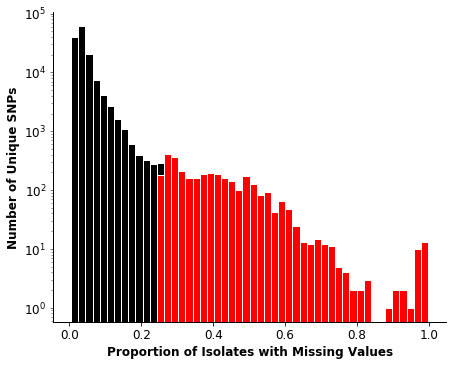

In [64]:
fig , ax = plt.subplots()

n , bins , patches = plt.hist( missing_values_per_SNP / number_of_isolates , bins = 50 , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=1.0)
plt.hist( missing_values_per_SNP[missing_values_per_SNP > max_number_values_missing_per_SNP] / number_of_isolates , bins = bins , color = 'red' , rwidth = 1.0 , edgecolor='white', linewidth=1.0)

#plt.title('Mean Coverage across sequenced isolates in rollingDB', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.xlabel('Proportion of Isolates with Missing Values', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.ylabel('Number of Unique SNPs', fontweight = 'bold' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')
ax.set_yscale("log", nonposy='clip')

fig = plt.gcf()
fig.set_size_inches(6.5, 5.25)
fig.tight_layout()

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

#file_name = '/home/rv76/Farhat_Lab/Figures/Final_5/Scraping_rollingDB/Mean_Coverage_Distribution_across_all_isolates.pdf'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [65]:
print 'Number of Isolates = ' + str( number_of_isolates )

Number of Isolates = 33873.0


Range and Average Number of Missing Values per SNP

In [66]:
np.min(missing_values_per_SNP)

166

In [67]:
np.mean(missing_values_per_SNP)

1681.338931735388

In [68]:
np.max(missing_values_per_SNP) 

33805

In [69]:
print 'SNP with most missing values is missing from ' + str( float(np.max(missing_values_per_SNP) ) / number_of_isolates * 100) + '% of isolates' 

SNP with most missing values is missing from 99.7992501402% of isolates


Drop SNPs that are flagged as 'missing values' in more than 25% of isolates in rollingDB

In [70]:
print sum( missing_values_per_SNP > max_number_values_missing_per_SNP )

3220


Percentage of SNPs with many missing values that we're going to drop from analysis

In [71]:
number_of_unique_SNPs = float(np.shape(genotypes_matrix)[0])
print 100.0 * ( sum( missing_values_per_SNP > max_number_values_missing_per_SNP ) / number_of_unique_SNPs )

2.251480593216191


#### FILTER out sites with missing calls in $> 25\%$ of isolates

Drop unique SNPs with a high abundance of missing values

In [72]:
np.shape( genotypes_matrix )

(143017, 33873)

Drop unique SNPs from the __GENOTYPE MATRIX__

In [73]:
len( missing_values_per_SNP <= max_number_values_missing_per_SNP )

143017

In [74]:
SNPs_to_keep_filter = missing_values_per_SNP <= max_number_values_missing_per_SNP

In [75]:
sum(SNPs_to_keep_filter)

139797

In [76]:
genotypes_matrix = genotypes_matrix[SNPs_to_keep_filter , :]

In [77]:
np.shape(genotypes_matrix) #Genotype Matrix

(139797, 33873)

Drop unique SNPs with a high abundance of missing values from the __SNP ANNOTATION FILE__

In [78]:
SNP_annotation_DF = SNP_annotation_DF[SNPs_to_keep_filter]

#re-index new filtered SNP annotation DF (so new index matches indexing of genotypes matrix rows)
SNP_annotation_DF.reset_index(drop = True , inplace = True)

In [79]:
SNP_annotation_DF.head()

,pos,ref,alt
0,29,C,[G]
1,31,A,"[C, G]"
2,48,C,[T]
3,64,G,[C]
4,71,C,[T]


In [80]:
np.shape(SNP_annotation_DF) #Annotation for Rows of Genotypes Matrix

(139797, 3)

## [9.2] Drop low-quality isolates

### (Filter 4) *FILTER* out isolates that have missing base calls $> 25\%$ of SNP sites

#### Investigate the Number of Missing Calls for each Sequenced Isolate

Look for isolates with an abundance of missing values, drop isolates that have missing values > 25% of SNP calls

In [99]:
missing_values = genotypes_matrix == 9
missing_values_per_isolate = missing_values.sum(axis = 0) #will range from 0 - 139,797

In [100]:
#impose a threshold for maximum number of missing values per isolate (across all SNPs)
max_proportion_missing = 0.25
number_of_SNPs = float(np.shape(genotypes_matrix)[0])

max_number_values_missing_per_isolate = np.floor( max_proportion_missing * number_of_SNPs )

In [101]:
print max_number_values_missing_per_isolate #that we're going to allow

34949.0


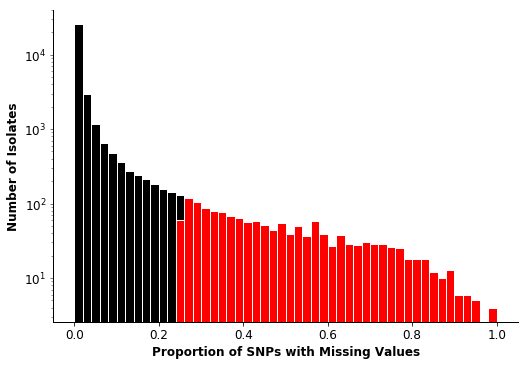

In [102]:
fig , ax = plt.subplots()

n , bins , patches = plt.hist( missing_values_per_isolate / number_of_SNPs , bins = 50 , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=1.0)
plt.hist( missing_values_per_isolate[missing_values_per_isolate > max_number_values_missing_per_isolate] / number_of_SNPs , bins = bins , color = 'red' , rwidth = 1.0 , edgecolor='white', linewidth=1.0)


#plt.title('Mean Coverage across sequenced isolates in rollingDB', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.xlabel('Proportion of SNPs with Missing Values', fontweight = 'bold' , fontsize = 12, color = 'k')
plt.ylabel('Number of Isolates', fontweight = 'bold' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')
ax.set_yscale("log", nonposy='clip')

fig = plt.gcf()
fig.set_size_inches(7.5, 5.25)
fig.tight_layout()

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

#file_name = '/home/rv76/Farhat_Lab/Figures/Final_5/Scraping_rollingDB/Mean_Coverage_Distribution_across_all_isolates.pdf'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [103]:
print 'Number of unique SNPs = ' + str( number_of_SNPs )

Number of unique SNPs = 139797.0


Range and Average Number of Missing Values per unique SNP

In [104]:
np.min(missing_values_per_isolate)

54

In [105]:
np.mean(missing_values_per_isolate)

5819.3169781241695

In [106]:
np.max(missing_values_per_isolate) 

139797

In [107]:
print 'Isolate with most missing values has ' + str( float(np.max(missing_values_per_isolate) ) / number_of_SNPs * 100) + '% missing values' 

Isolate with most missing values has 100.0% missing values


Drop isolates that are flagged as 'missing values' in more than 25% of isolates in rollingDB

In [108]:
print sum( missing_values_per_isolate > max_number_values_missing_per_isolate )

1518


Percentage of isolates with many missing values that we're going to drop from analysis

In [109]:
number_of_unique_isolates = float(np.shape(genotypes_matrix)[1])
print 100.0 * ( sum( missing_values_per_isolate > max_number_values_missing_per_isolate ) / number_of_unique_isolates )

4.481445398990346


#### FILTER out low-quality isolates with $> 25\%$ missing SNP calls

Drop unique isolates with a high abundance of missing values

In [110]:
np.shape( genotypes_matrix )

(139797, 33873)

Drop isolates from the __GENOTYPE MATRIX__

In [111]:
len( missing_values_per_isolate <= max_number_values_missing_per_isolate )

33873

In [112]:
isolates_to_keep_filter = missing_values_per_isolate <= max_number_values_missing_per_isolate

In [113]:
sum(isolates_to_keep_filter)

32355

In [114]:
genotypes_matrix = genotypes_matrix[: , isolates_to_keep_filter]

In [115]:
np.shape(genotypes_matrix) #Genotype Matrix

(139797, 32355)

Drop isolates with a high abundance of missing values from __ISOLATE ANNOTATION FILE__

In [116]:
isolate_annotation_series = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes/genotypes_isolate_annotation.pkl')

In [117]:
isolate_annotation_series.head()

0    SAMEA3558733
1    SAMN05575260
2    SAMN03648641
3    SAMN03647419
4    SAMEA3671418
dtype: object

In [118]:
np.shape(isolate_annotation_series) #Annotation for Columns of Genotypes Matrix

(33873,)

In [119]:
isolate_annotation_series = isolate_annotation_series[isolates_to_keep_filter]

#re-index new filtered isolate annotation series (so new index matches indexing of genotypes matrix columns)
isolate_annotation_series.reset_index(drop = True , inplace = True)

In [120]:
isolate_annotation_series.head()

0    SAMEA3558733
1    SAMN03648641
2    SAMN03647419
3    SAMEA3671418
4    SAMN07659096
dtype: object

In [121]:
np.shape(isolate_annotation_series) #Annotation for Columns of Genotypes Matrix

(32355,)

#### Save annotation files and genotypes matrix

In [122]:
#save isolate annotation file (columns of Genotype Matrix)
isolate_annotation_series.to_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_isolate_annotation.pkl')

#save SNP annotation file (rows of Genotype Matrix)
SNP_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_SNP_annotation.pkl')

#save Genotypes Matrix
np.save('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_matrix' , genotypes_matrix , allow_pickle = True)

####################################################################################################################################################################################

## [9] Annotate SNPs w/ H37Rv Locus Info

####################################################################################################################################################################################

#### Retrieve information for H37Rv Reference Genome

In [3]:
####################################################################################################################################################################################
#load reference genome and reference annotation
reference_genome = '/home/rv76/Farhat_Lab/Reference_Seqs/H37Rv/h37rv.fasta'
for reference_genome in SeqIO.parse(reference_genome, "fasta"):
    reference_genome.seq.alphabet = IUPAC.unambiguous_dna

reference_genome_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt', '\t').set_index('name')

####### Make a dictionary of all H37Rv reference positions and corresponding genes #######
ReferencePosition_Gene_mapping = {} #keys: H37Rv Reference Positions , values: gene_ids (may be multiple genes for some Reference Positions)

#store a list corresponding to every Reference Position (to store all genes that map to the Reference Position)
for H37Rv_RefPos in range(0 , len(reference_genome.seq) + 1):
    ReferencePosition_Gene_mapping[H37Rv_RefPos] = []

for gene_id_index in range(0 , len(reference_genome_annotation.index)):

    gene_id_info = reference_genome_annotation.ix[gene_id_index , :]
    gene_id = gene_id_info.name

    chrom_start = gene_id_info.chromStart
    chrom_end = gene_id_info.chromEnd

    #find the position of the first base relative to H37Rv in 5' -> 3'
    H37Rv_start = min(chrom_start , chrom_end)
    H37Rv_end = max(chrom_start , chrom_end)

    #store all corresponding H37Rv Reference Positions to gene_id in dictionary
    for H37Rv_RefPos in range(H37Rv_start+1 , H37Rv_end+1):

        ReferencePosition_Gene_mapping[H37Rv_RefPos].append(gene_id) #append gene_id to list already in dict
####################################################################################################################################################################################

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


#### Annotate SNPs

To annotate SNPs, we get gene_ids that the SNPs 'land in' and the gene-relative coordinate.

In [4]:
#load SNP annotation file (rows of Genotype Matrix)
SNP_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_SNP_annotation.pkl')

SNP_annotation_DF.head()

,pos,ref,alt
0,29,C,[G]
1,31,A,"[C, G]"
2,48,C,[T]
3,64,G,[C]
4,71,C,[T]


In [5]:
np.shape(SNP_annotation_DF)

(139797, 3)

#### Gene Categories

In [6]:
#get Gene Categories
gene_categories = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/gene_categories/gene_categories.csv').set_index('name')

#create dictionary, keys: H37Rv locus, values: gene category
gene_categories_map = dict( zip( list(gene_categories.gene_id) , list(gene_categories.Gene_Category) ) ) 

#### Gene Names

Parse through Mycobrowser (tuberculist) to collect gene names

In [7]:
mycobrowser_table = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/Mycobrowser_Release3/Mycobacterium_tuberculosis_H37Rv_txt_v3.txt' , sep = '\t')

#retreive columns for locus tag & gene name
mycobrowser_table = mycobrowser_table.loc[: , ['Locus' , 'Name']]

#create dictionary, keys: H37Rv loucs, values: gene category
gene_names_map = dict( zip( list(mycobrowser_table.Locus) , list(mycobrowser_table.Name) ) ) 

#### Iterate through each SNP to annotate

Some SNPs are present in more than 1 gene, have to account for this

In [8]:
#create dictionaries for each columsn of information
locus_tag_dict = {} #H37Rv id
genomic_coord_dict = {} #coordinate on gene, 5' -> 3'
gene_categ_dict = {} #gene Category
gene_name_dict = {} #gene Name

for SNP_index in SNP_annotation_DF.index:

    #reference position, ref allele and alt allele for SNP
    SNP_info = SNP_annotation_DF.loc[SNP_index , :]

    #find the gene that SNP occurs on
    ref_seq_position = SNP_info.pos

    #check list corresponding to H37Rv coordinate to see if there are any genes associated with RefPosition
    if len(ReferencePosition_Gene_mapping[ref_seq_position]) > 0:
        
        #create lists to store annotation information for SNP and associated gene(s)
        gene_intergenic_id_list = []
        gene_relative_coord_list = []
        gene_categ_list = []
        gene_name_list = []

        #iterate through all genes that ReferencePosition is mapped to (i.e. SNP might correspond to 2 genes)
        for gene_intergenic_id in ReferencePosition_Gene_mapping[ref_seq_position]:

            #find genomic coordinate of SNP relative to gene (subtract 1 since reference seq starts counting at 1)
            gene_relative_coord = (ref_seq_position - 1) - min( reference_genome_annotation.loc[gene_intergenic_id , 'chromStart'] , reference_genome_annotation.loc[gene_intergenic_id , 'chromEnd'] )

            gene_intergenic_id_list.append( gene_intergenic_id )
            gene_relative_coord_list.append( gene_relative_coord )
            
            #use gene id to get category and names from mappings
            if gene_intergenic_id in gene_categories_map.keys():
                gene_categ_list.append( gene_categories_map[gene_intergenic_id] )
            else:
                gene_categ_list.append( 'None' )
                
            if gene_intergenic_id in gene_names_map.keys():
                gene_name_list.append( gene_names_map[gene_intergenic_id] ) 
            else:
                gene_name_list.append( 'None' )

        #store all information for SNP in relevant dictionaries
        locus_tag_dict[SNP_index] = gene_intergenic_id_list
        genomic_coord_dict[SNP_index] = gene_relative_coord_list
        gene_categ_dict[SNP_index] = gene_categ_list
        gene_name_dict[SNP_index] = gene_name_list
            
    #H37Rv RefSeq position was not found in dictionary so Reference position must be intergenic    
    elif len(ReferencePosition_Gene_mapping[ref_seq_position]) == 0:

        #store all information for SNP in relevant dictionaries
        locus_tag_dict[SNP_index] = ['intergenic']
        genomic_coord_dict[SNP_index] = [np.nan]
        gene_categ_dict[SNP_index] = ['None']
        gene_name_dict[SNP_index] = ['None']

    #keep track of progress of loop
    num_SNPs = float( np.shape(SNP_annotation_DF)[0] )
    if SNP_index % np.ceil(0.20 * num_SNPs) == 0:
        print float(SNP_index) / num_SNPs

0.0
0.200004291938
0.400008583875
0.600012875813
0.80001716775


#### Update SNP annotation DF

In [9]:
#append columns for info from annotation
SNP_annotation_DF['gene_id'] = pd.Series(locus_tag_dict)
SNP_annotation_DF['gene_pos'] = pd.Series(genomic_coord_dict)
SNP_annotation_DF['gene_category'] = pd.Series(gene_categ_dict)
SNP_annotation_DF['gene_name'] = pd.Series(gene_name_dict)

In [10]:
np.shape( SNP_annotation_DF )

(139797, 7)

In [11]:
SNP_annotation_DF.head()

,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
0,29,C,[G],[Rv0001],[28],[Essential],[dnaA]
1,31,A,"[C, G]",[Rv0001],[30],[Essential],[dnaA]
2,48,C,[T],[Rv0001],[47],[Essential],[dnaA]
3,64,G,[C],[Rv0001],[63],[Essential],[dnaA]
4,71,C,[T],[Rv0001],[70],[Essential],[dnaA]


In [12]:
SNP_annotation_DF.tail()

,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
139792,4411459,C,"[T, G]",[intergenic],[nan],[None],[None]
139793,4411467,C,[T],[intergenic],[nan],[None],[None]
139794,4411475,G,[A],[intergenic],[nan],[None],[None]
139795,4411485,G,"[A, C]",[intergenic],[nan],[None],[None]
139796,4411501,C,[T],[intergenic],[nan],[None],[None]


In [13]:
#update SNP annotation file (rows of Genotype Matrix) with extra SNP information
SNP_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/rolling_DB_scrape/Genotypes_Filtered/genotypes_SNP_annotation_with_gene_info.pkl')

How to investigate SNPs that appeared on more than 1 gene

In [14]:
SNP_annotation_DF[ SNP_annotation_DF.gene_name.apply(len) > 1 ].head()

,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
3337,60400,C,[T],"[Rv0057, Rv0058]","[504, 4]","[Non-Essential, Essential]","[Rv0057, dnaB]"
3338,60414,C,[T],"[Rv0057, Rv0058]","[518, 18]","[Non-Essential, Essential]","[Rv0057, dnaB]"
4089,77620,C,[G],"[Rv0069c, Rv0070c]","[1383, 1]","[Non-Essential, Non-Essential]","[sdaA, glyA2]"
4751,95414,G,"[A, C]","[Rv0086, Rv0087]","[1463, 0]","[Essential, Non-Essential]","[hycQ, hycE]"
4752,95415,T,[C],"[Rv0086, Rv0087]","[1464, 1]","[Essential, Non-Essential]","[hycQ, hycE]"


How to investigate SNPs that appeared within a particular gene

In [15]:
SNP_annotation_DF[['Rv0667' in gene_list for gene_list in SNP_annotation_DF.gene_id]].head()

,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
27629,759814,A,[G],[Rv0667],[7],[Antibiotic Resistance],[rpoB]
27630,759818,C,[T],[Rv0667],[11],[Antibiotic Resistance],[rpoB]
27631,759841,G,[C],[Rv0667],[34],[Antibiotic Resistance],[rpoB]
27632,759852,A,[T],[Rv0667],[45],[Antibiotic Resistance],[rpoB]
27633,759862,A,[G],[Rv0667],[55],[Antibiotic Resistance],[rpoB]
